In [32]:
%pip install -q git+https://github.com/yfukai/BaSiCPy@autosegment

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


# Install and import 

In [ ]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets, metrics
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from os import path
from skimage import filters
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.family"] = "sans-serif"

In [ ]:
estimated_parameters_df = pd.read_csv(
    "wo_flatfield_estimated_parameters_df_with_autotune.csv", index_col=0
)

In [ ]:
estimated_parameters_df.head()

true_flatfield_id  intensity  ave_count  n_images blob_dist_key  rep  \
0                  0         10          0        10        biased    0   
1                  0         10          0        10        biased    0   
2                  0         10          0        10        biased    0   
3                  0         10          0        10        biased    0   
4                  0         10          0        10        biased    0   

   image_index fitting_mode  smoothness_flatfield  time_gpu  time_cpu  \
0            0       ladmap              0.100000  0.053855       NaN   
1            0       ladmap              0.261016  0.041438       NaN   
2            0       ladmap              0.681292  0.038933       NaN   
3            0       ladmap              1.778279  0.038915       NaN   
4            0       ladmap              4.641589  0.038668       NaN   

   deviation   entropy  fourier_L0_norm  autotune_cost  
0   0.024315  1.251328         0.323984    3231.094215  
1   0.018550  1.277066         0.152571    1516.992053  
2   0.008840  1.307435         0.020805     199.359479  
3   0.005247  1.326257         0.000245       1.326257  
4   0.010590  1.335022         0.000000       1.335022

# Plot execution time

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/874274570.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k, grp2 in grp.groupby(["true_flatfield_id"]):


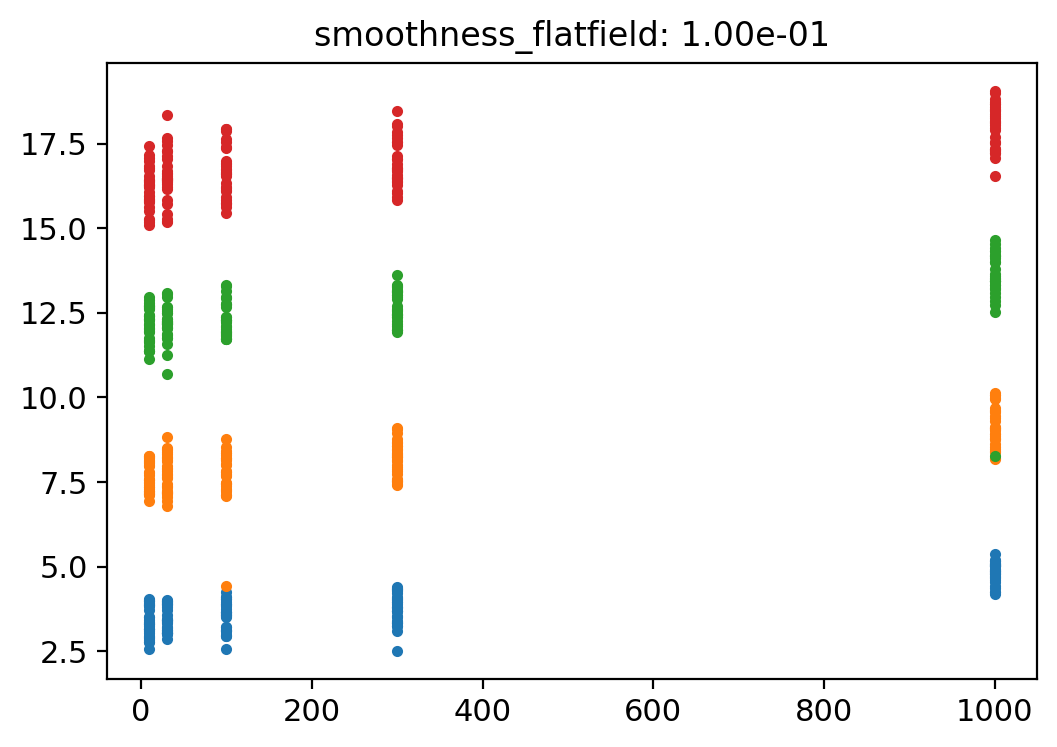

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/874274570.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k, grp2 in grp.groupby(["true_flatfield_id"]):


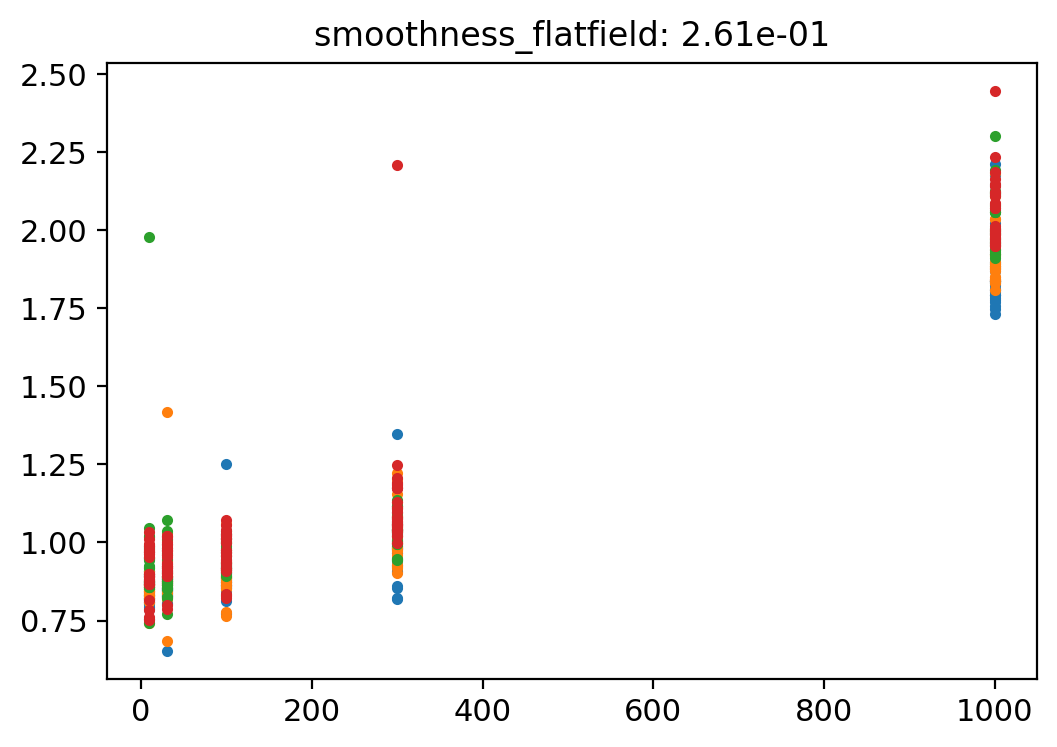

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/874274570.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k, grp2 in grp.groupby(["true_flatfield_id"]):


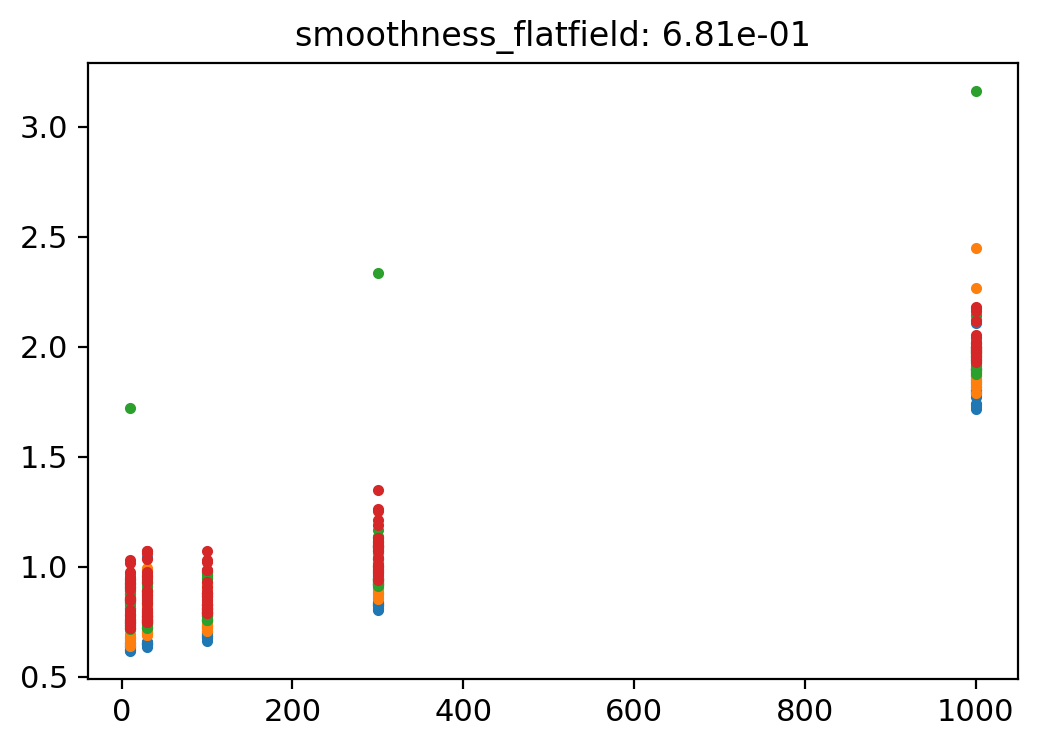

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/874274570.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k, grp2 in grp.groupby(["true_flatfield_id"]):


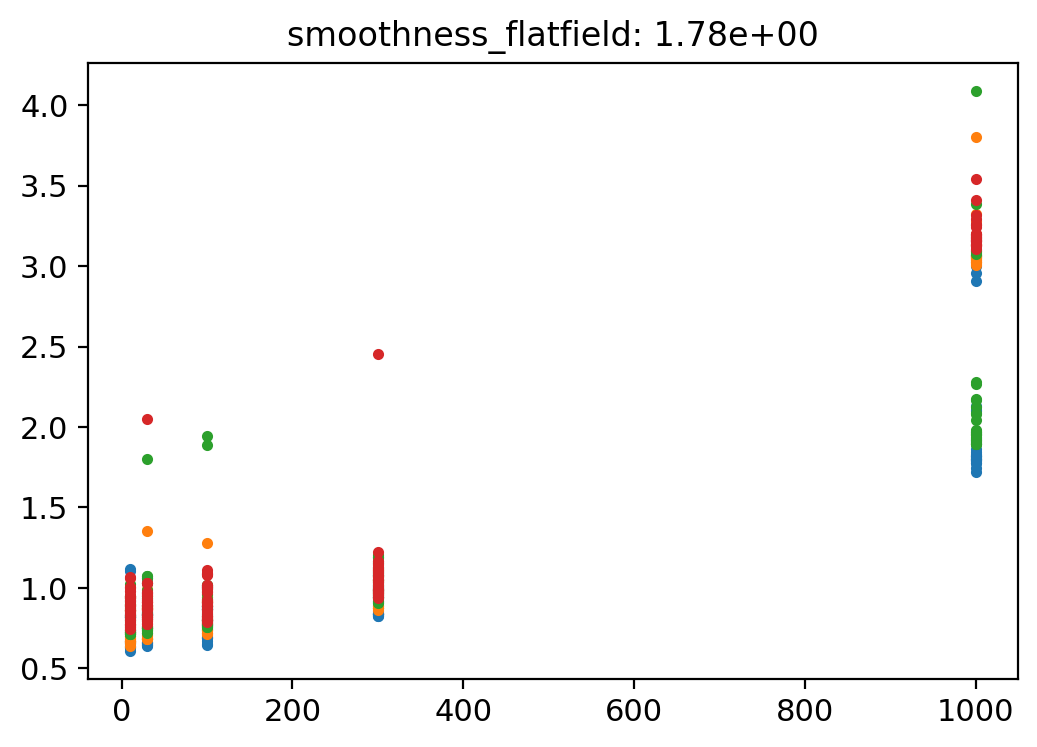

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/874274570.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k, grp2 in grp.groupby(["true_flatfield_id"]):


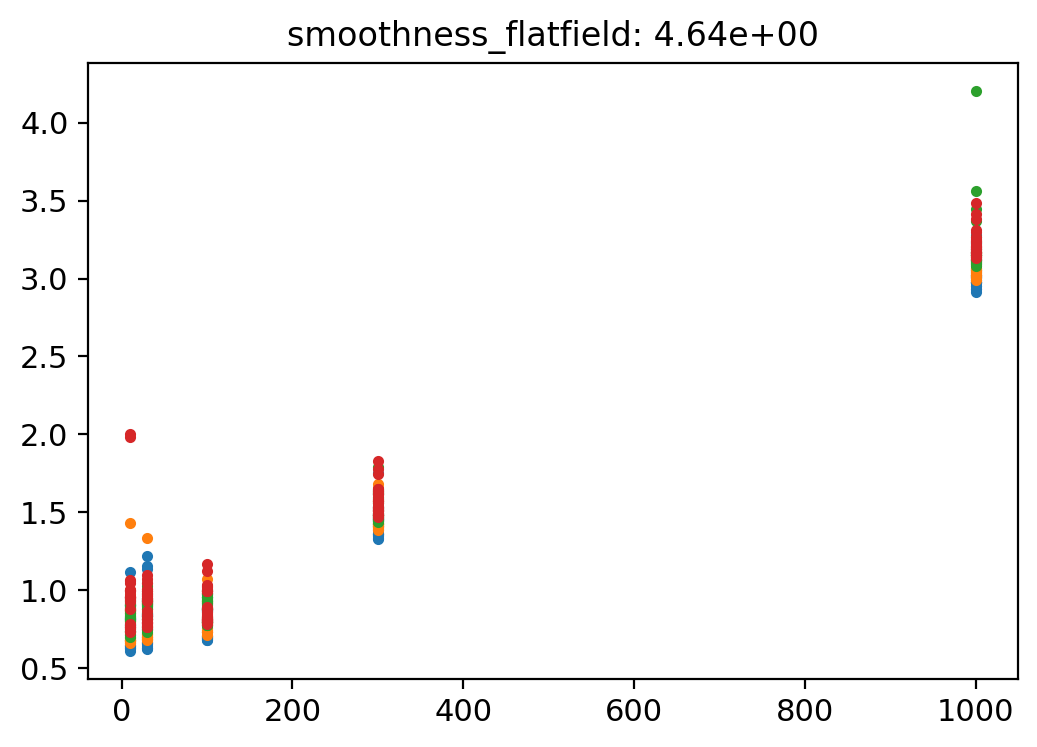

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/874274570.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k, grp2 in grp.groupby(["true_flatfield_id"]):


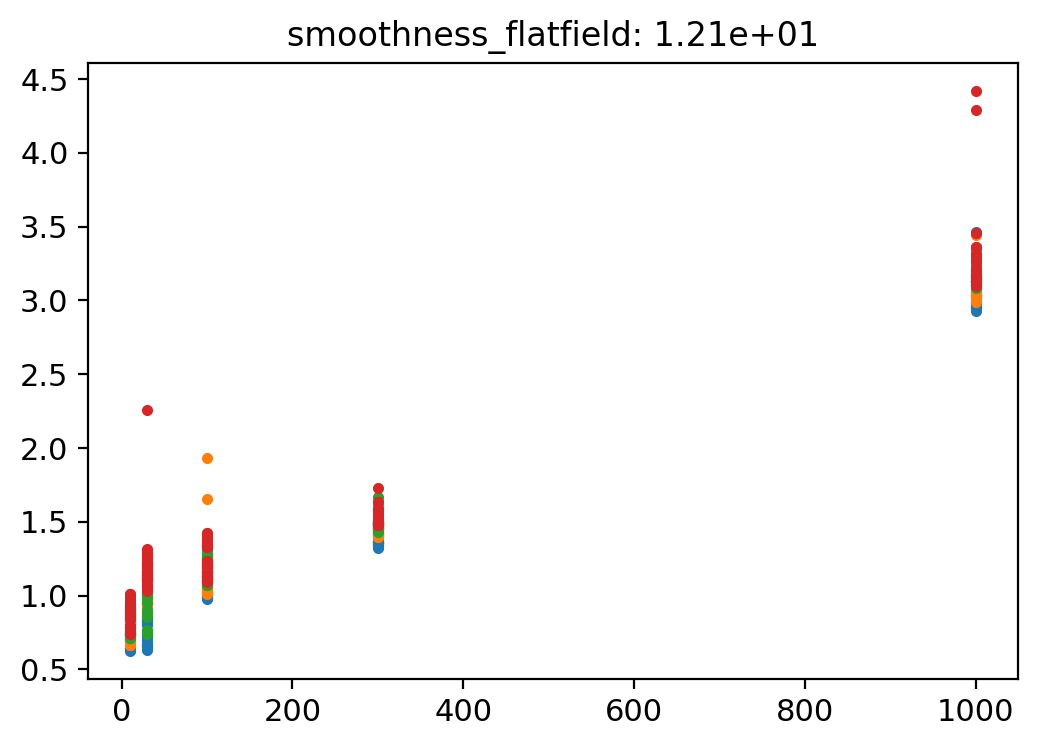

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/874274570.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k, grp2 in grp.groupby(["true_flatfield_id"]):


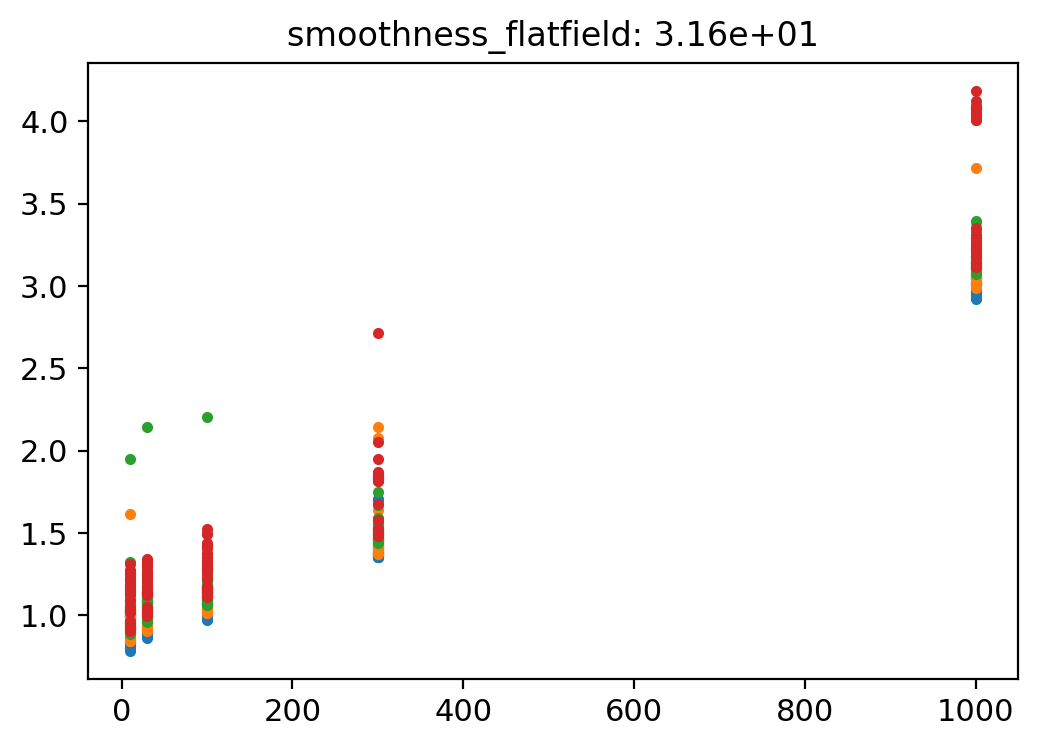

In [ ]:
df = estimated_parameters_df.query("intensity==100 and fitting_mode=='ladmap'")
for sf, grp in df.groupby("smoothness_flatfield"):
    for k, grp2 in grp.groupby(["true_flatfield_id"]):
        plt.plot(grp2["n_images"], grp2["time_gpu"], ".")
    plt.title(f"smoothness_flatfield: {sf:.2e}")
    plt.show()

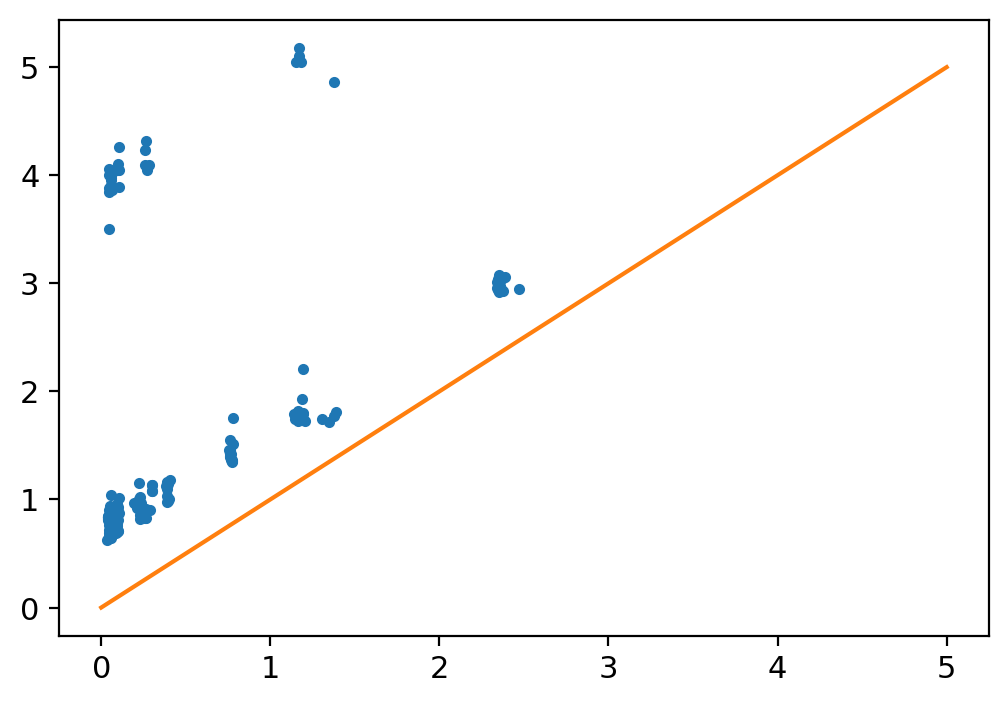

In [ ]:
plt.plot(df["time_cpu"], df["time_gpu"], ".")
plt.plot([0, 5], [0, 5])

# Calculate deviation

In [ ]:
_, grp1 = list(grp.groupby("rep"))[0]

In [ ]:
grp1["deviation"].idxmin()

11

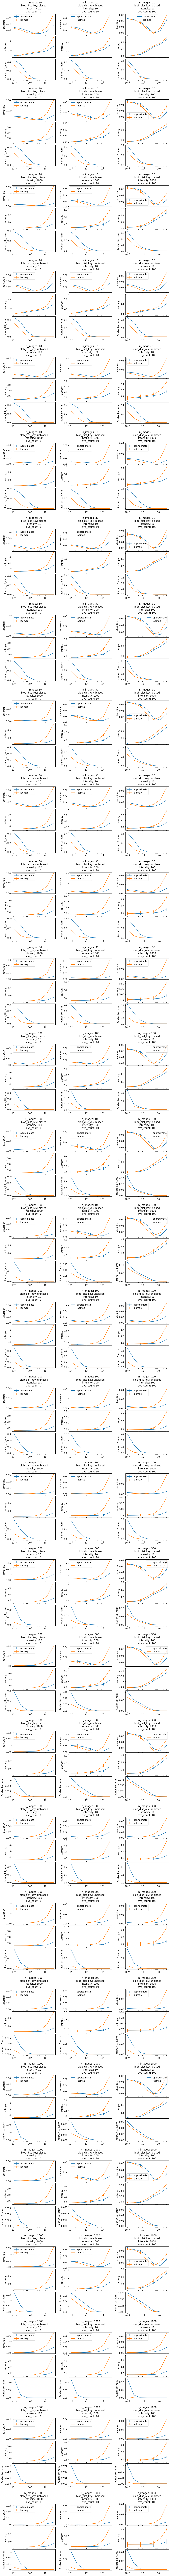

In [48]:
df = estimated_parameters_df[estimated_parameters_df["true_flatfield_id"] == 1]
image_properties = ["n_images", "blob_dist_key", "intensity", "ave_count"]
keys = list(
    set(estimated_parameters_df.keys())
    - {
        "smoothness_flatfield",
        "deviation",
        "true_flatfield_id",
        "image_index",
        "time",
        "rep",
        "entropy",
        "fourier_L0_norm",
        "autotune_cost",
        "time_gpu",
        "time_cpu",
        *image_properties,
    }
)
assert len(keys) == 1

num_imagess = df["ave_count"].unique().tolist()
ncols = len(num_imagess)
grps = list(df.groupby(image_properties))
nrows = (len(grps) - 1) // ncols + 1

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 6 * nrows),
    # gridspec_kw={"hspace": 1.5, "wspace": 1.0},
    dpi=50,
)
summaried_df_data = []

for ii, (image_property, grp0) in enumerate(df.groupby(image_properties)):
    ax = axes[ii // ncols, ii % ncols]
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="100%", pad=0.1, sharex=ax)
    ax3 = divider.append_axes("bottom", size="100%", pad=0.1, sharex=ax)
    for key, grp in grp0.groupby(keys[0]):
        d = {k: v for k, v in zip(image_properties, image_property)}
        d[keys[0]] = key

        min_deviation_smoothness_flatfield = [
            grp1.loc[grp1["deviation"].idxmin()]["smoothness_flatfield"]
            for _, grp1 in grp.groupby("rep")
        ]
        d["min_deviation_smoothness_flatfield_max"] = np.max(
            min_deviation_smoothness_flatfield
        )
        d["min_deviation_smoothness_flatfield_median"] = np.median(
            min_deviation_smoothness_flatfield
        )
        d["min_deviation_smoothness_flatfield_min"] = np.min(
            min_deviation_smoothness_flatfield
        )
        summaried_df_data.append(d)
        for _ax, name in zip(
            [ax, ax2, ax3], ["deviation", "entropy", "fourier_L0_norm"]
        ):
            vals = (
                grp.groupby("smoothness_flatfield")[name]
                .agg(["mean", "std"])
                .reset_index()
            )

            _ax.errorbar(
                vals["smoothness_flatfield"], vals["mean"], vals["std"], label=key
            )
            _ax.set_ylabel(name)

    ax.set_title(
        "\n".join([f"{k}: {v}" for k, v in zip(image_properties, image_property)]),
    )
    ax.legend()
    ax.set_xlabel("smoothness_flatfield")
    ax.set_xscale("log")

summaried_df = pd.DataFrame.from_records(summaried_df_data)

fig.tight_layout()

In [39]:
summaried_df.head()

n_images blob_dist_key  intensity  ave_count fitting_mode  \
0        10        biased         10          0  approximate   
1        10        biased         10          0       ladmap   
2        10        biased         10         10  approximate   
3        10        biased         10         10       ladmap   
4        10        biased         10        100  approximate   

   min_deviation_smoothness_flatfield_max  \
0                                4.641589   
1                                1.778279   
2                                4.641589   
3                                1.778279   
4                                4.641589   

   min_deviation_smoothness_flatfield_median  \
0                                   4.641589   
1                                   1.778279   
2                                   4.641589   
3                                   1.778279   
4                                   4.641589   

   min_deviation_smoothness_flatfield_min  
0                                4.641589  
1                                1.778279  
2                                4.641589  
3                                1.778279  
4                                4.641589

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


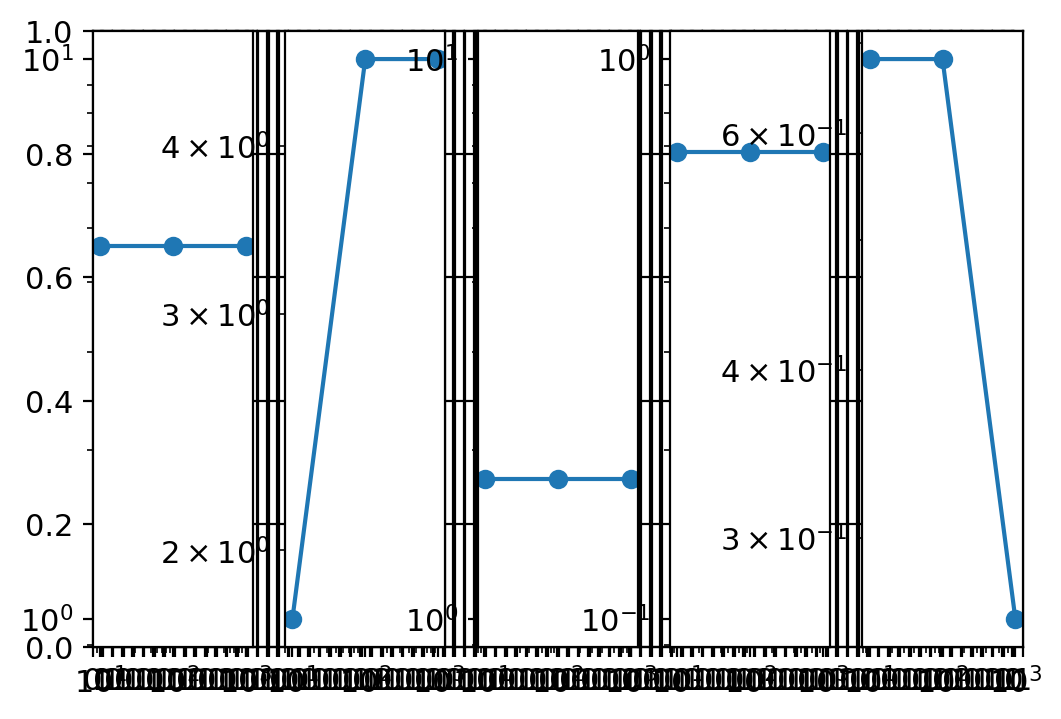

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


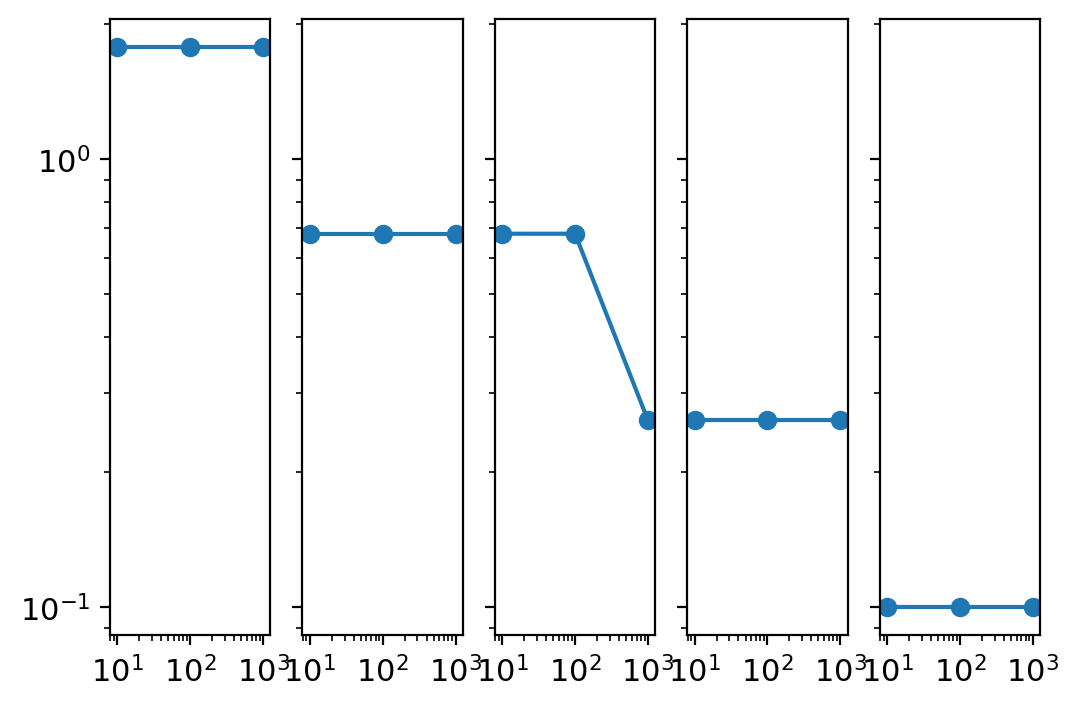

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


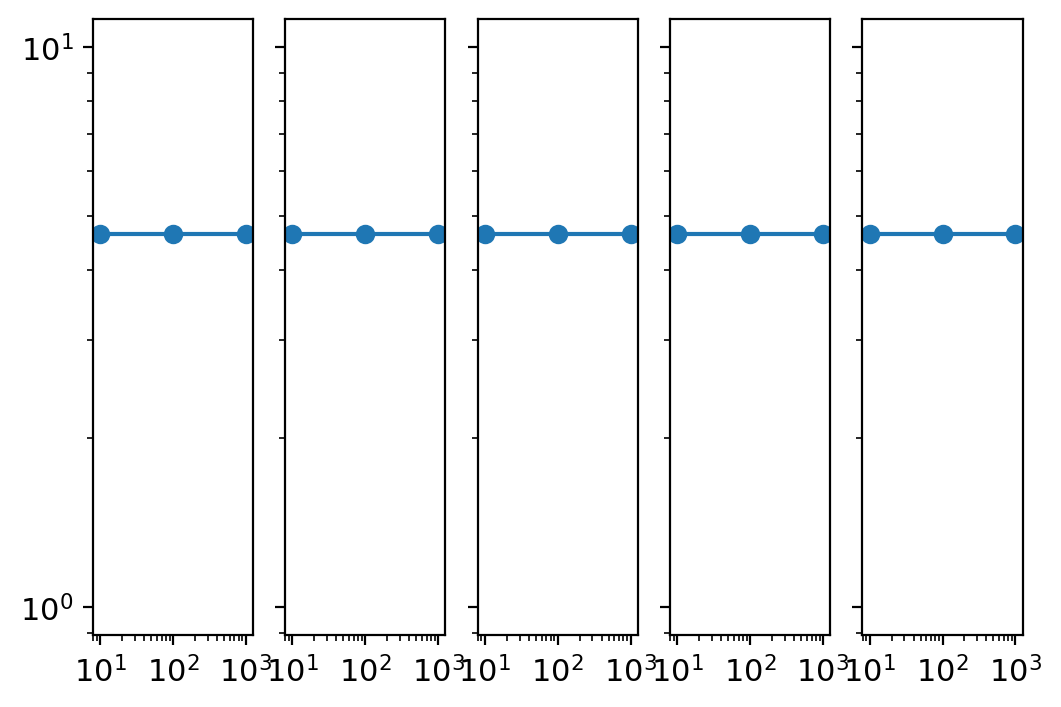

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


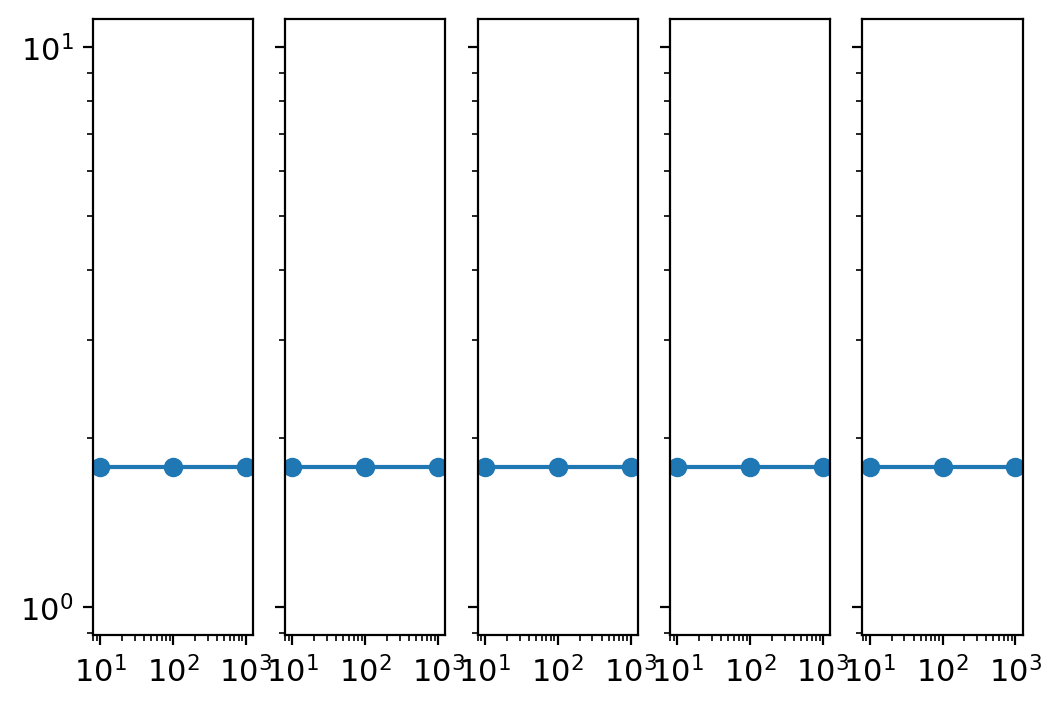

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


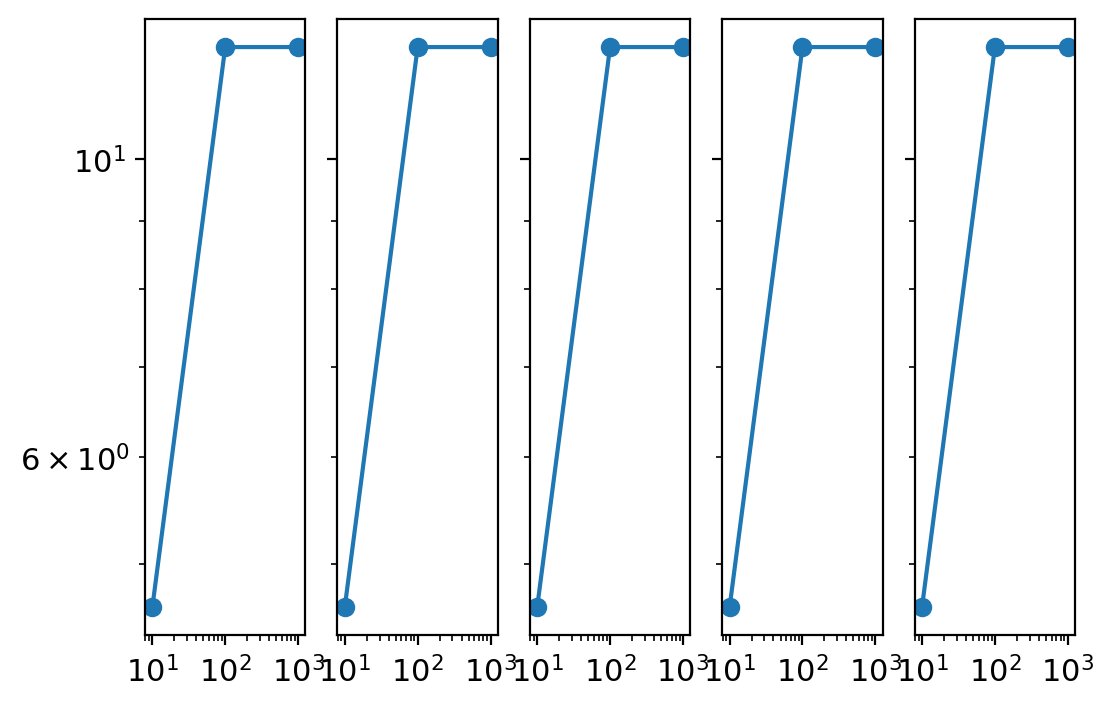

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


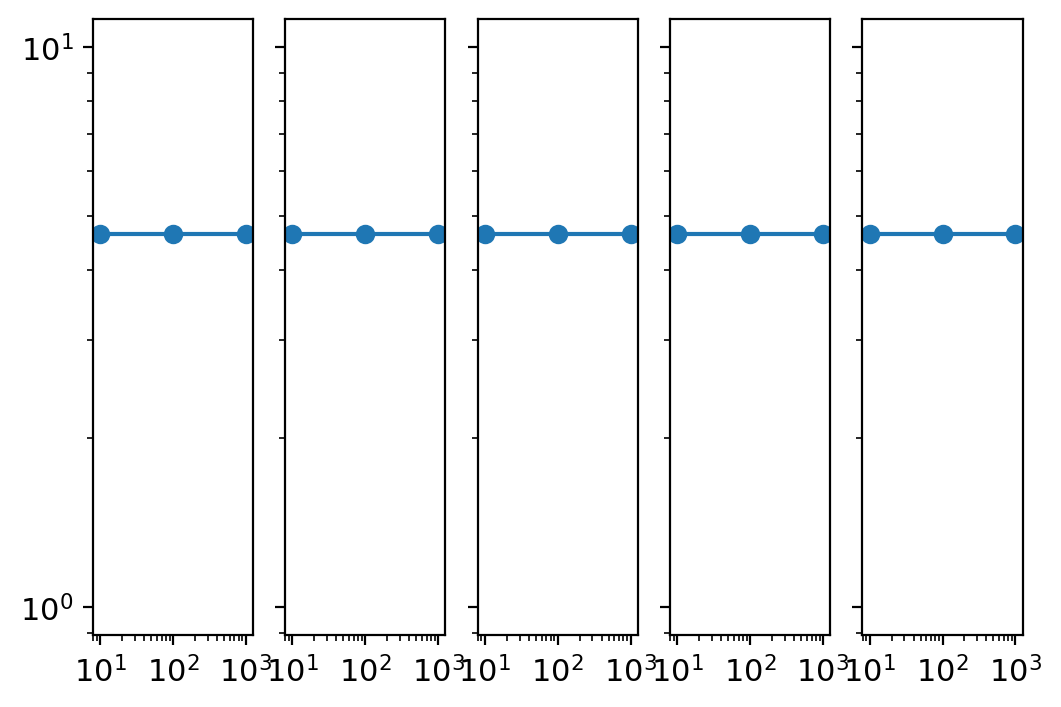

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


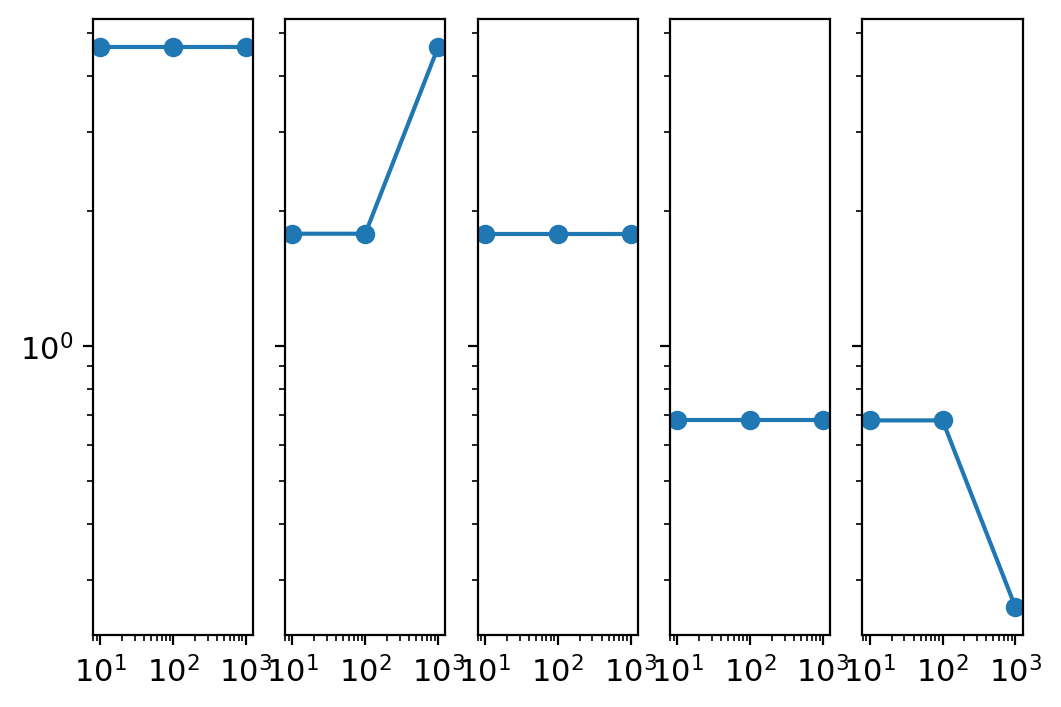

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


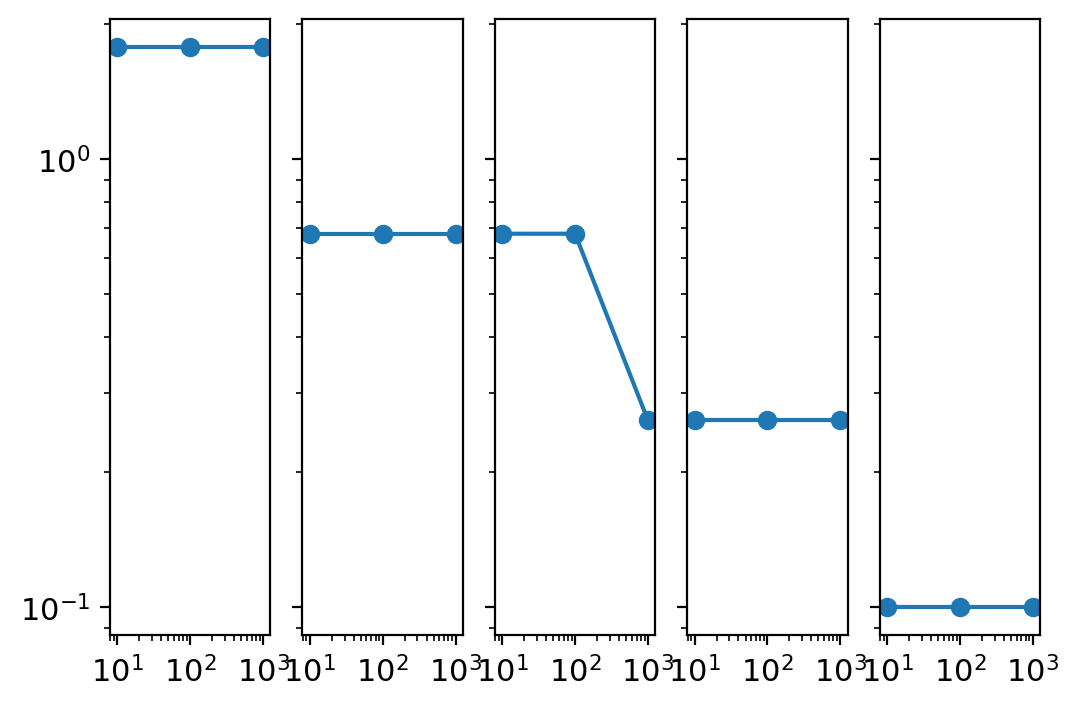

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


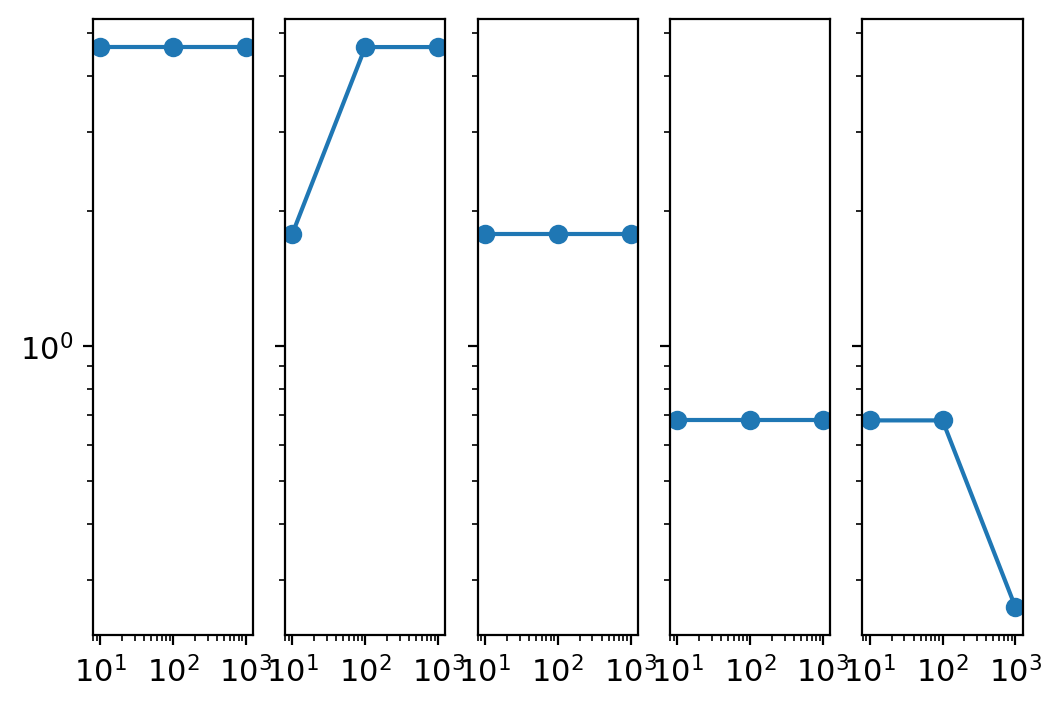

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


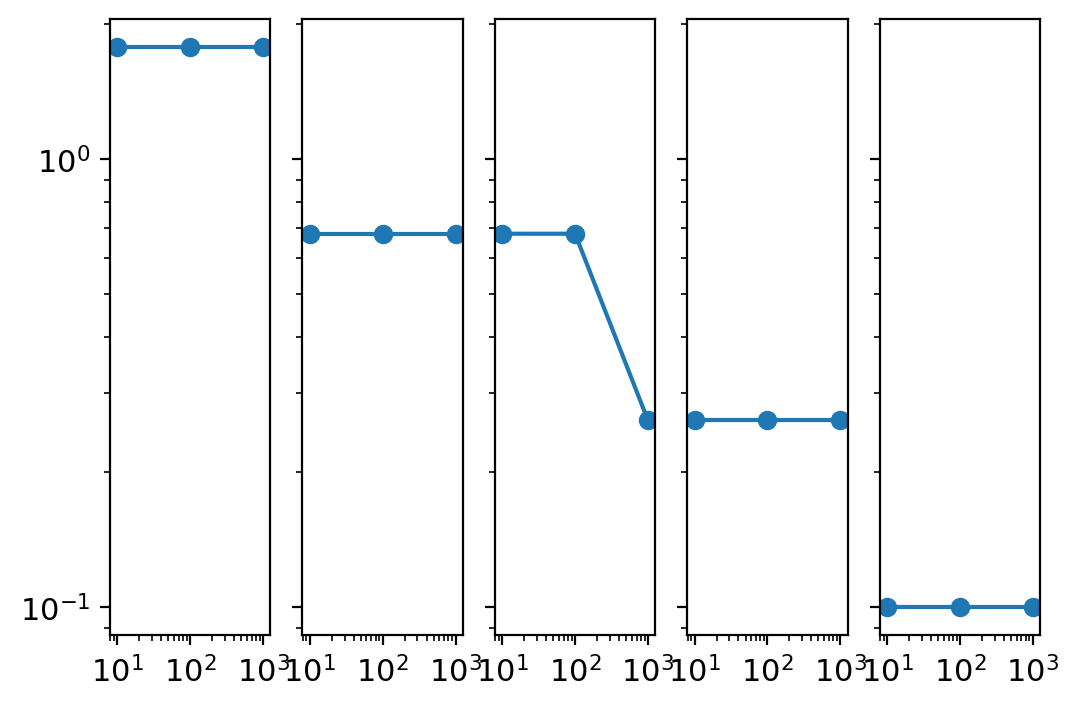

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


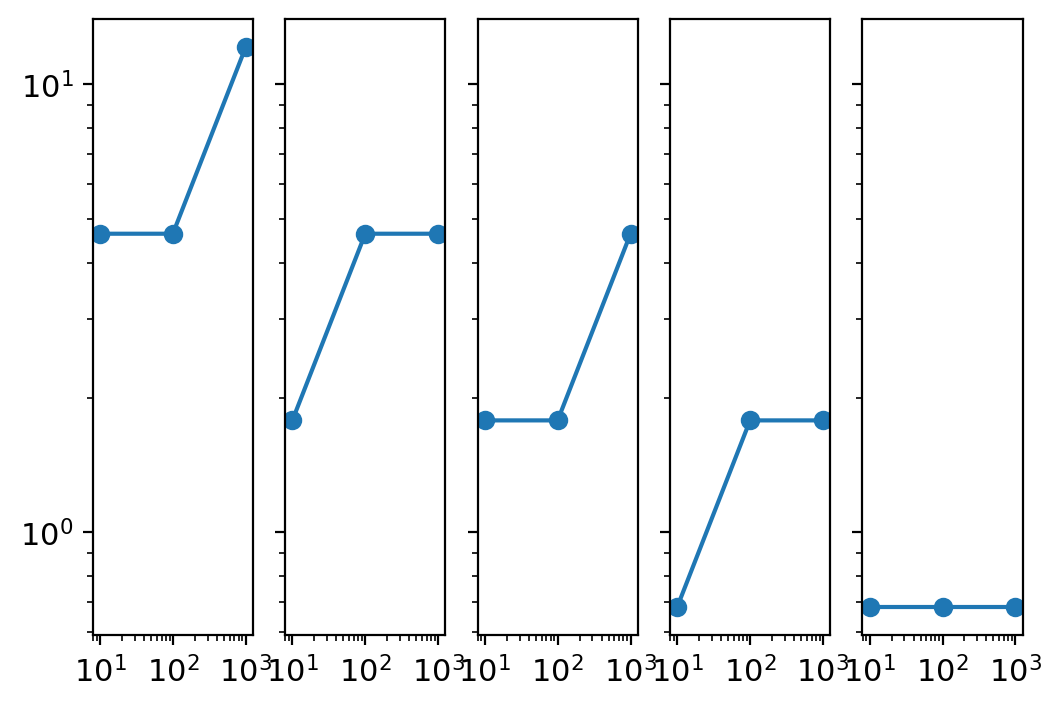

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/3195209818.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grps = list(grp0.groupby(["n_images"]))


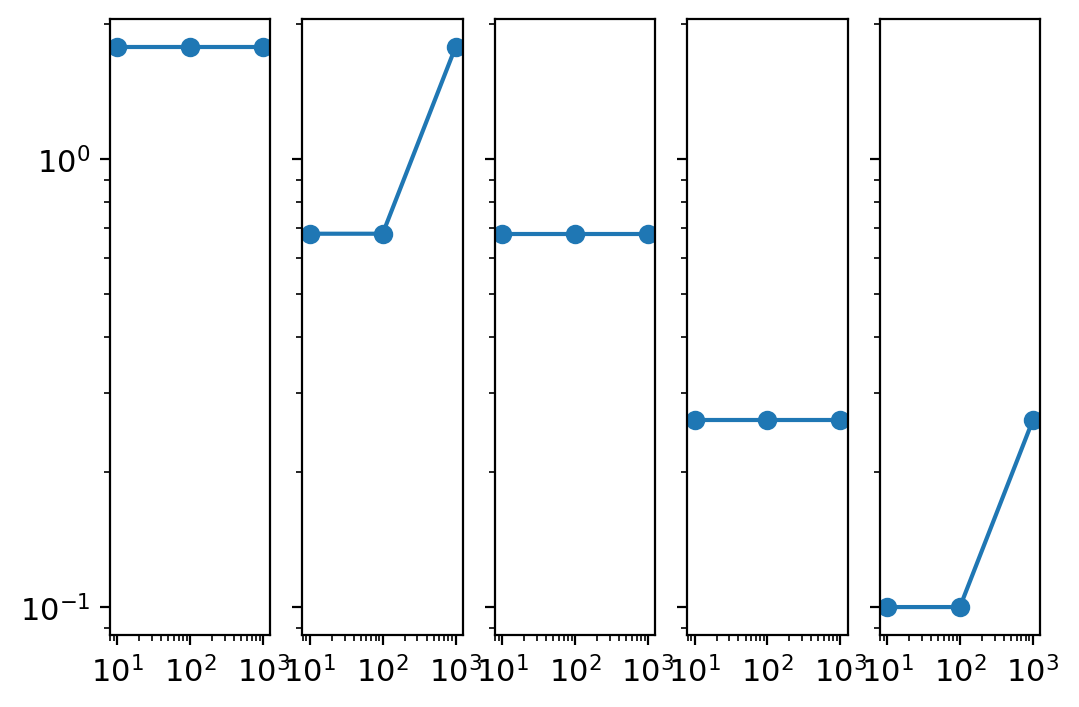

In [87]:
for image_property, grp0 in summaried_df.groupby(
    ["blob_dist_key", "ave_count", "fitting_mode"]
):
    plt.subplots(1, len(grps), sharey=True)
    grps = list(grp0.groupby(["n_images"]))
    for jj, (image_property, grp) in enumerate(grps):
        plt.subplot(1, len(grps), jj + 1)
        plt.plot(
            grp["intensity"], grp["min_deviation_smoothness_flatfield_median"], "o-"
        )
        """
        plt.fill_between(
            grp["intensity"],
            grp["min_deviation_smoothness_flatfield_min"],
            grp["min_deviation_smoothness_flatfield_max"],
            alpha=0.5,
        )
        """
        plt.xscale("log")
        plt.yscale("log")
    plt.show()

In [143]:
fourier_l0_norm_thresholds = np.linspace(0, 0.01, 10)
fourier_l0_norm_cost_coefs = [1, 2, 3, 5, 10, 20, 30, 50, 100]

In [144]:
def to_autotune_cost(
    entropy_value, n, fourier_l0_norm_threshold, fourier_l0_norm_cost_coef
):
    if n < fourier_l0_norm_threshold:
        fourier_L0_norm_cost = 0
    else:
        fourier_L0_norm_cost = (
            n - fourier_l0_norm_threshold
        ) * fourier_l0_norm_cost_coef
    return entropy_value + fourier_L0_norm_cost


to_autotune_cost = np.vectorize(to_autotune_cost)

all_ress = []
for fourier_l0_norm_threshold, fourier_l0_norm_cost_coef in tqdm(
    list(product(fourier_l0_norm_thresholds, fourier_l0_norm_cost_coefs))
):
    keys = image_properties + ["fitting_mode", "true_flatfield_id"]
    for vals, grp in estimated_parameters_df.groupby(keys):
        deviation_optimal_diffs = []
        for rep, grp2 in grp.groupby("rep"):
            autotune_cost = to_autotune_cost(
                grp2["entropy"],
                grp2["fourier_L0_norm"],
                fourier_l0_norm_threshold,
                fourier_l0_norm_cost_coef,
            )
            optimal_deviation = grp2["deviation"].min()
            estimated_deviation = grp2["deviation"].values[np.argmin(autotune_cost)]

            r = dict(zip(keys, vals))
            r["fourier_l0_norm_threshold"] = fourier_l0_norm_threshold
            r["fourier_l0_norm_cost_coef"] = fourier_l0_norm_cost_coef
            r["optimal_deviation"] = optimal_deviation
            r["estimated_deviation"] = estimated_deviation
            r["rep"] = rep
            all_ress.append(r)
deviation_df = pd.DataFrame.from_records(all_ress)

100%|██████████| 90/90 [00:50<00:00,  1.80it/s]


In [145]:
deviation_df["deviation_diff"] = (
    deviation_df["estimated_deviation"] - deviation_df["optimal_deviation"]
)
deviation_df2 = (
    deviation_df.groupby(
        keys + ["fourier_l0_norm_threshold", "fourier_l0_norm_cost_coef"]
    )
    .agg(["mean"])
    .reset_index()
)

In [146]:
deviation_df2.head()

n_images blob_dist_key intensity ave_count fitting_mode true_flatfield_id  \
                                                                              
0       10        biased        10         0  approximate                 0   
1       10        biased        10         0  approximate                 0   
2       10        biased        10         0  approximate                 0   
3       10        biased        10         0  approximate                 0   
4       10        biased        10         0  approximate                 0   

  fourier_l0_norm_threshold fourier_l0_norm_cost_coef optimal_deviation  \
                                                                   mean   
0                       0.0                         1          0.005444   
1                       0.0                         2          0.005444   
2                       0.0                         3          0.005444   
3                       0.0                         5          0.005444   
4                       0.0                        10          0.005444   

  estimated_deviation  rep deviation_diff  
                 mean mean           mean  
0            0.007611  2.0       0.002168  
1            0.005444  2.0       0.000000  
2            0.005444  2.0       0.000000  
3            0.005444  2.0       0.000000  
4            0.005444  2.0       0.000000

In [147]:
import warnings

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/864301079.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/864301079.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/864301079.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_1830/864301079.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


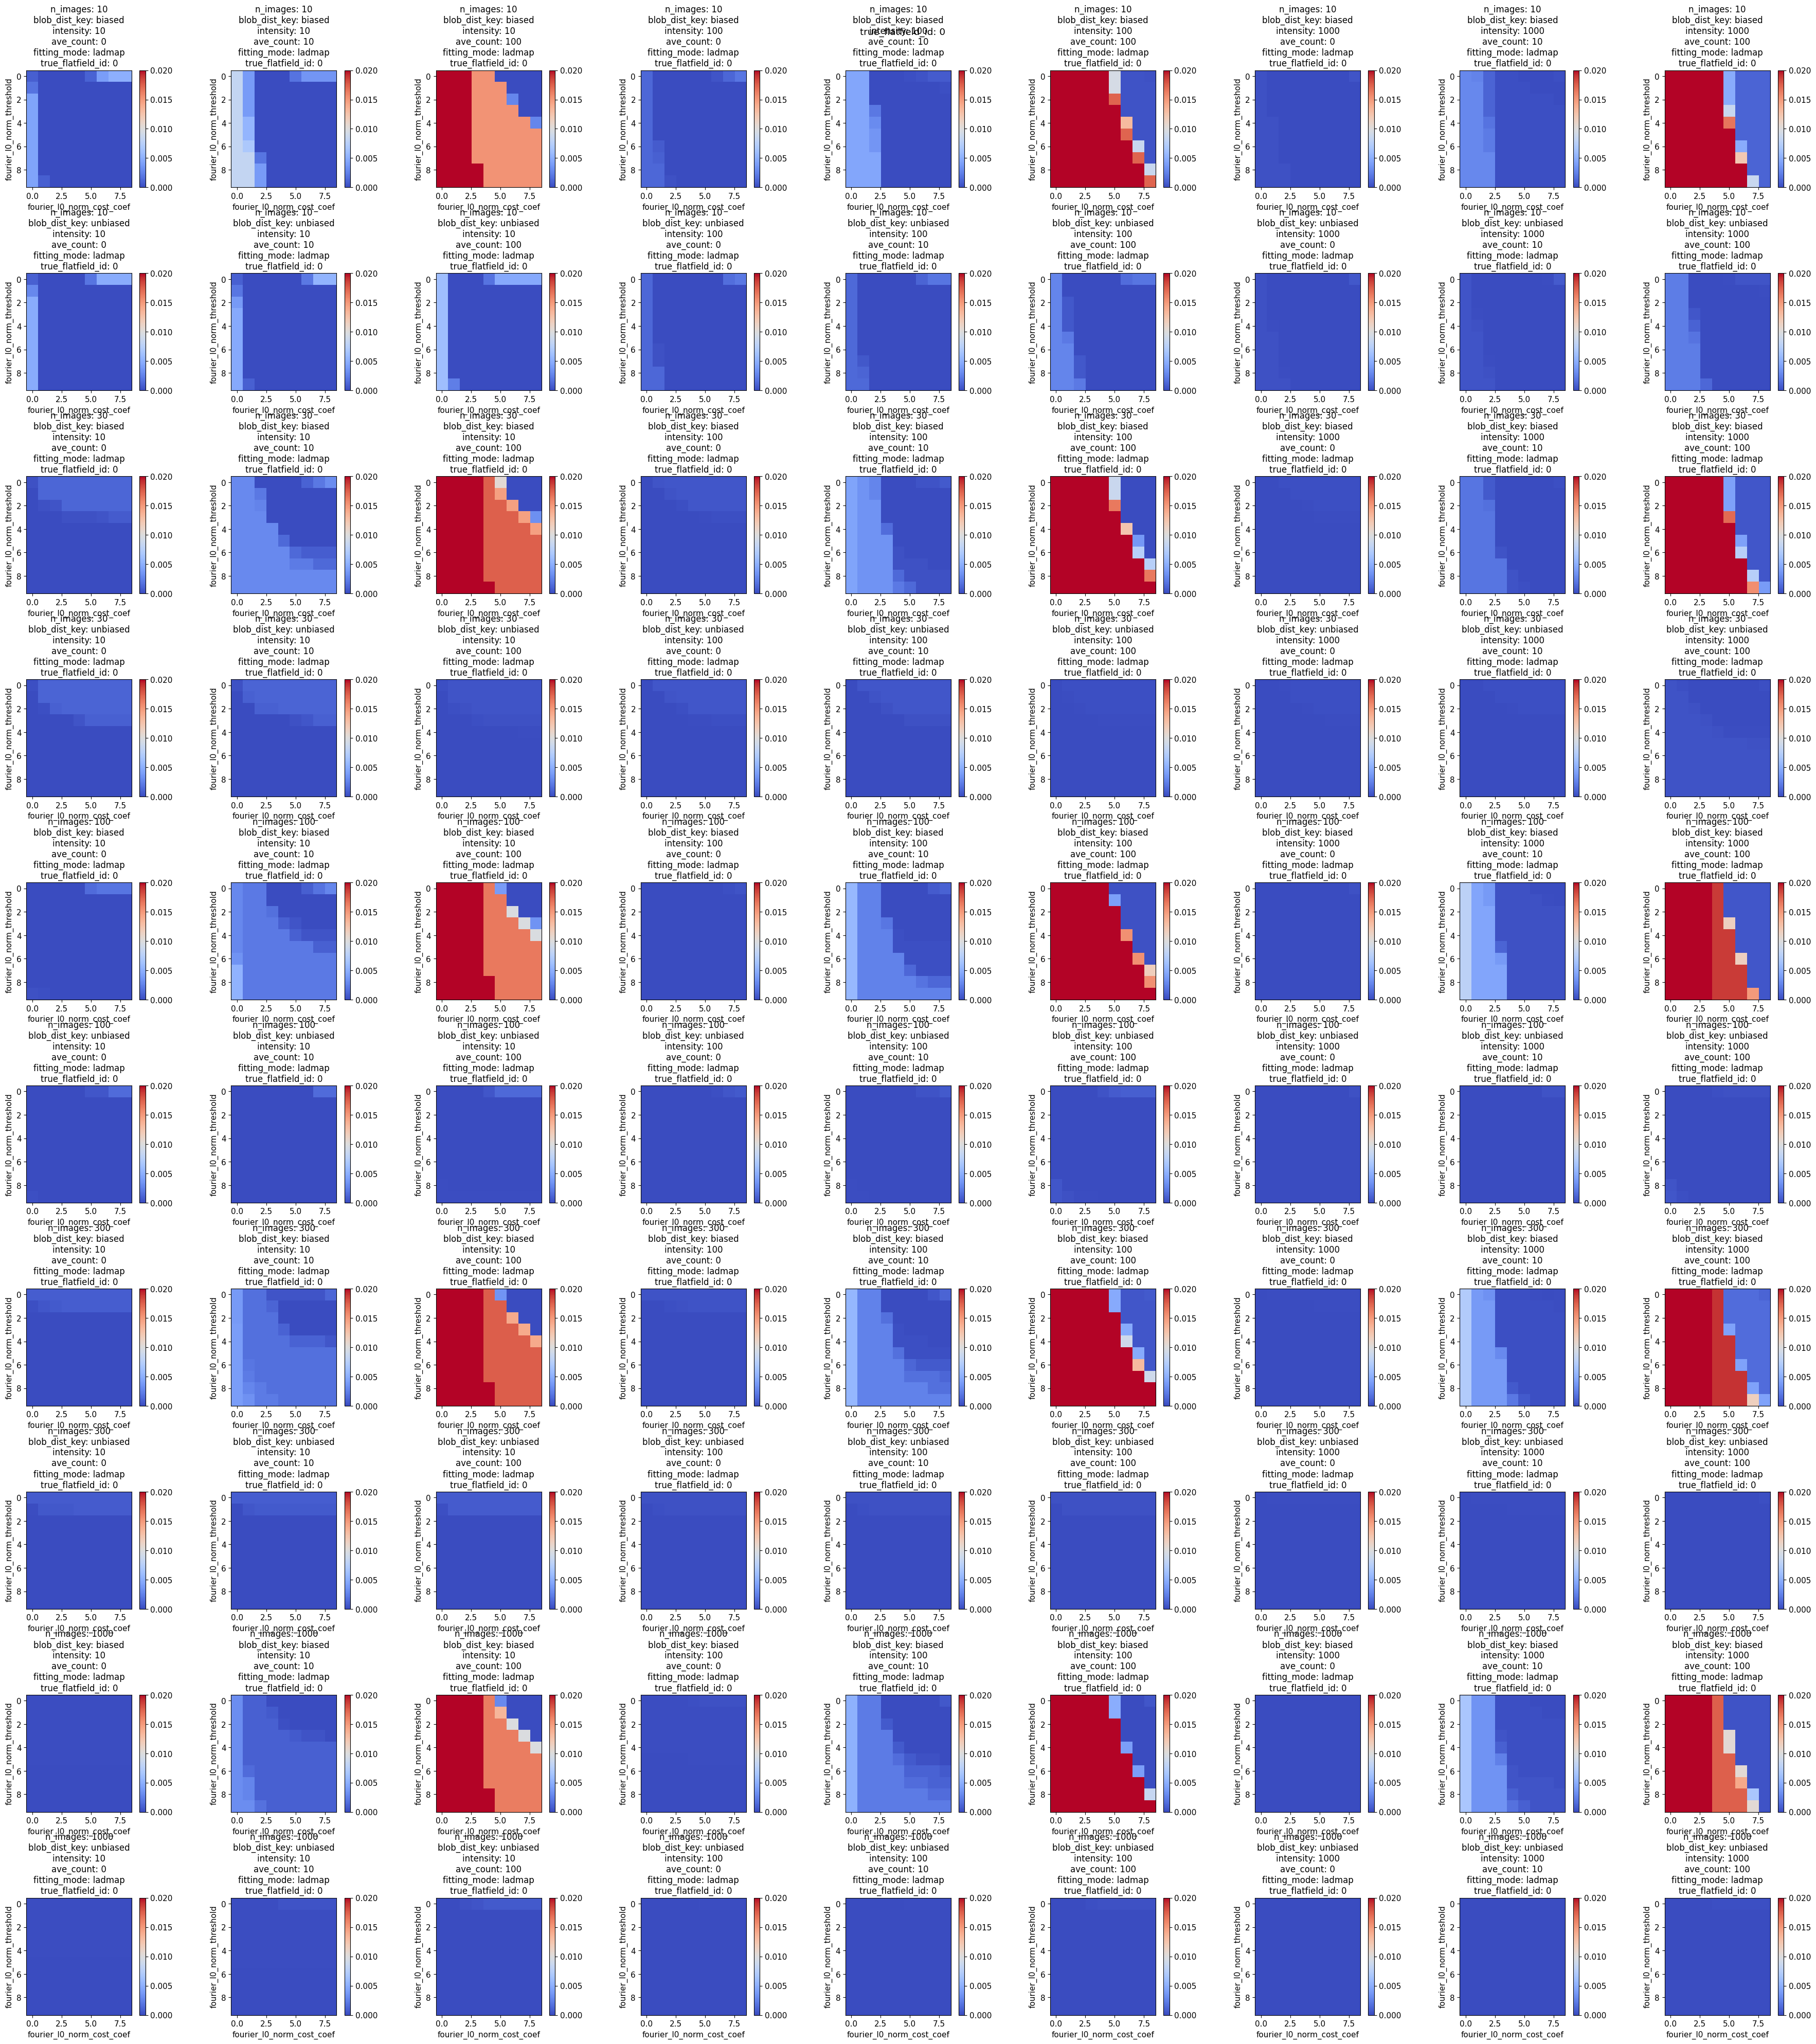

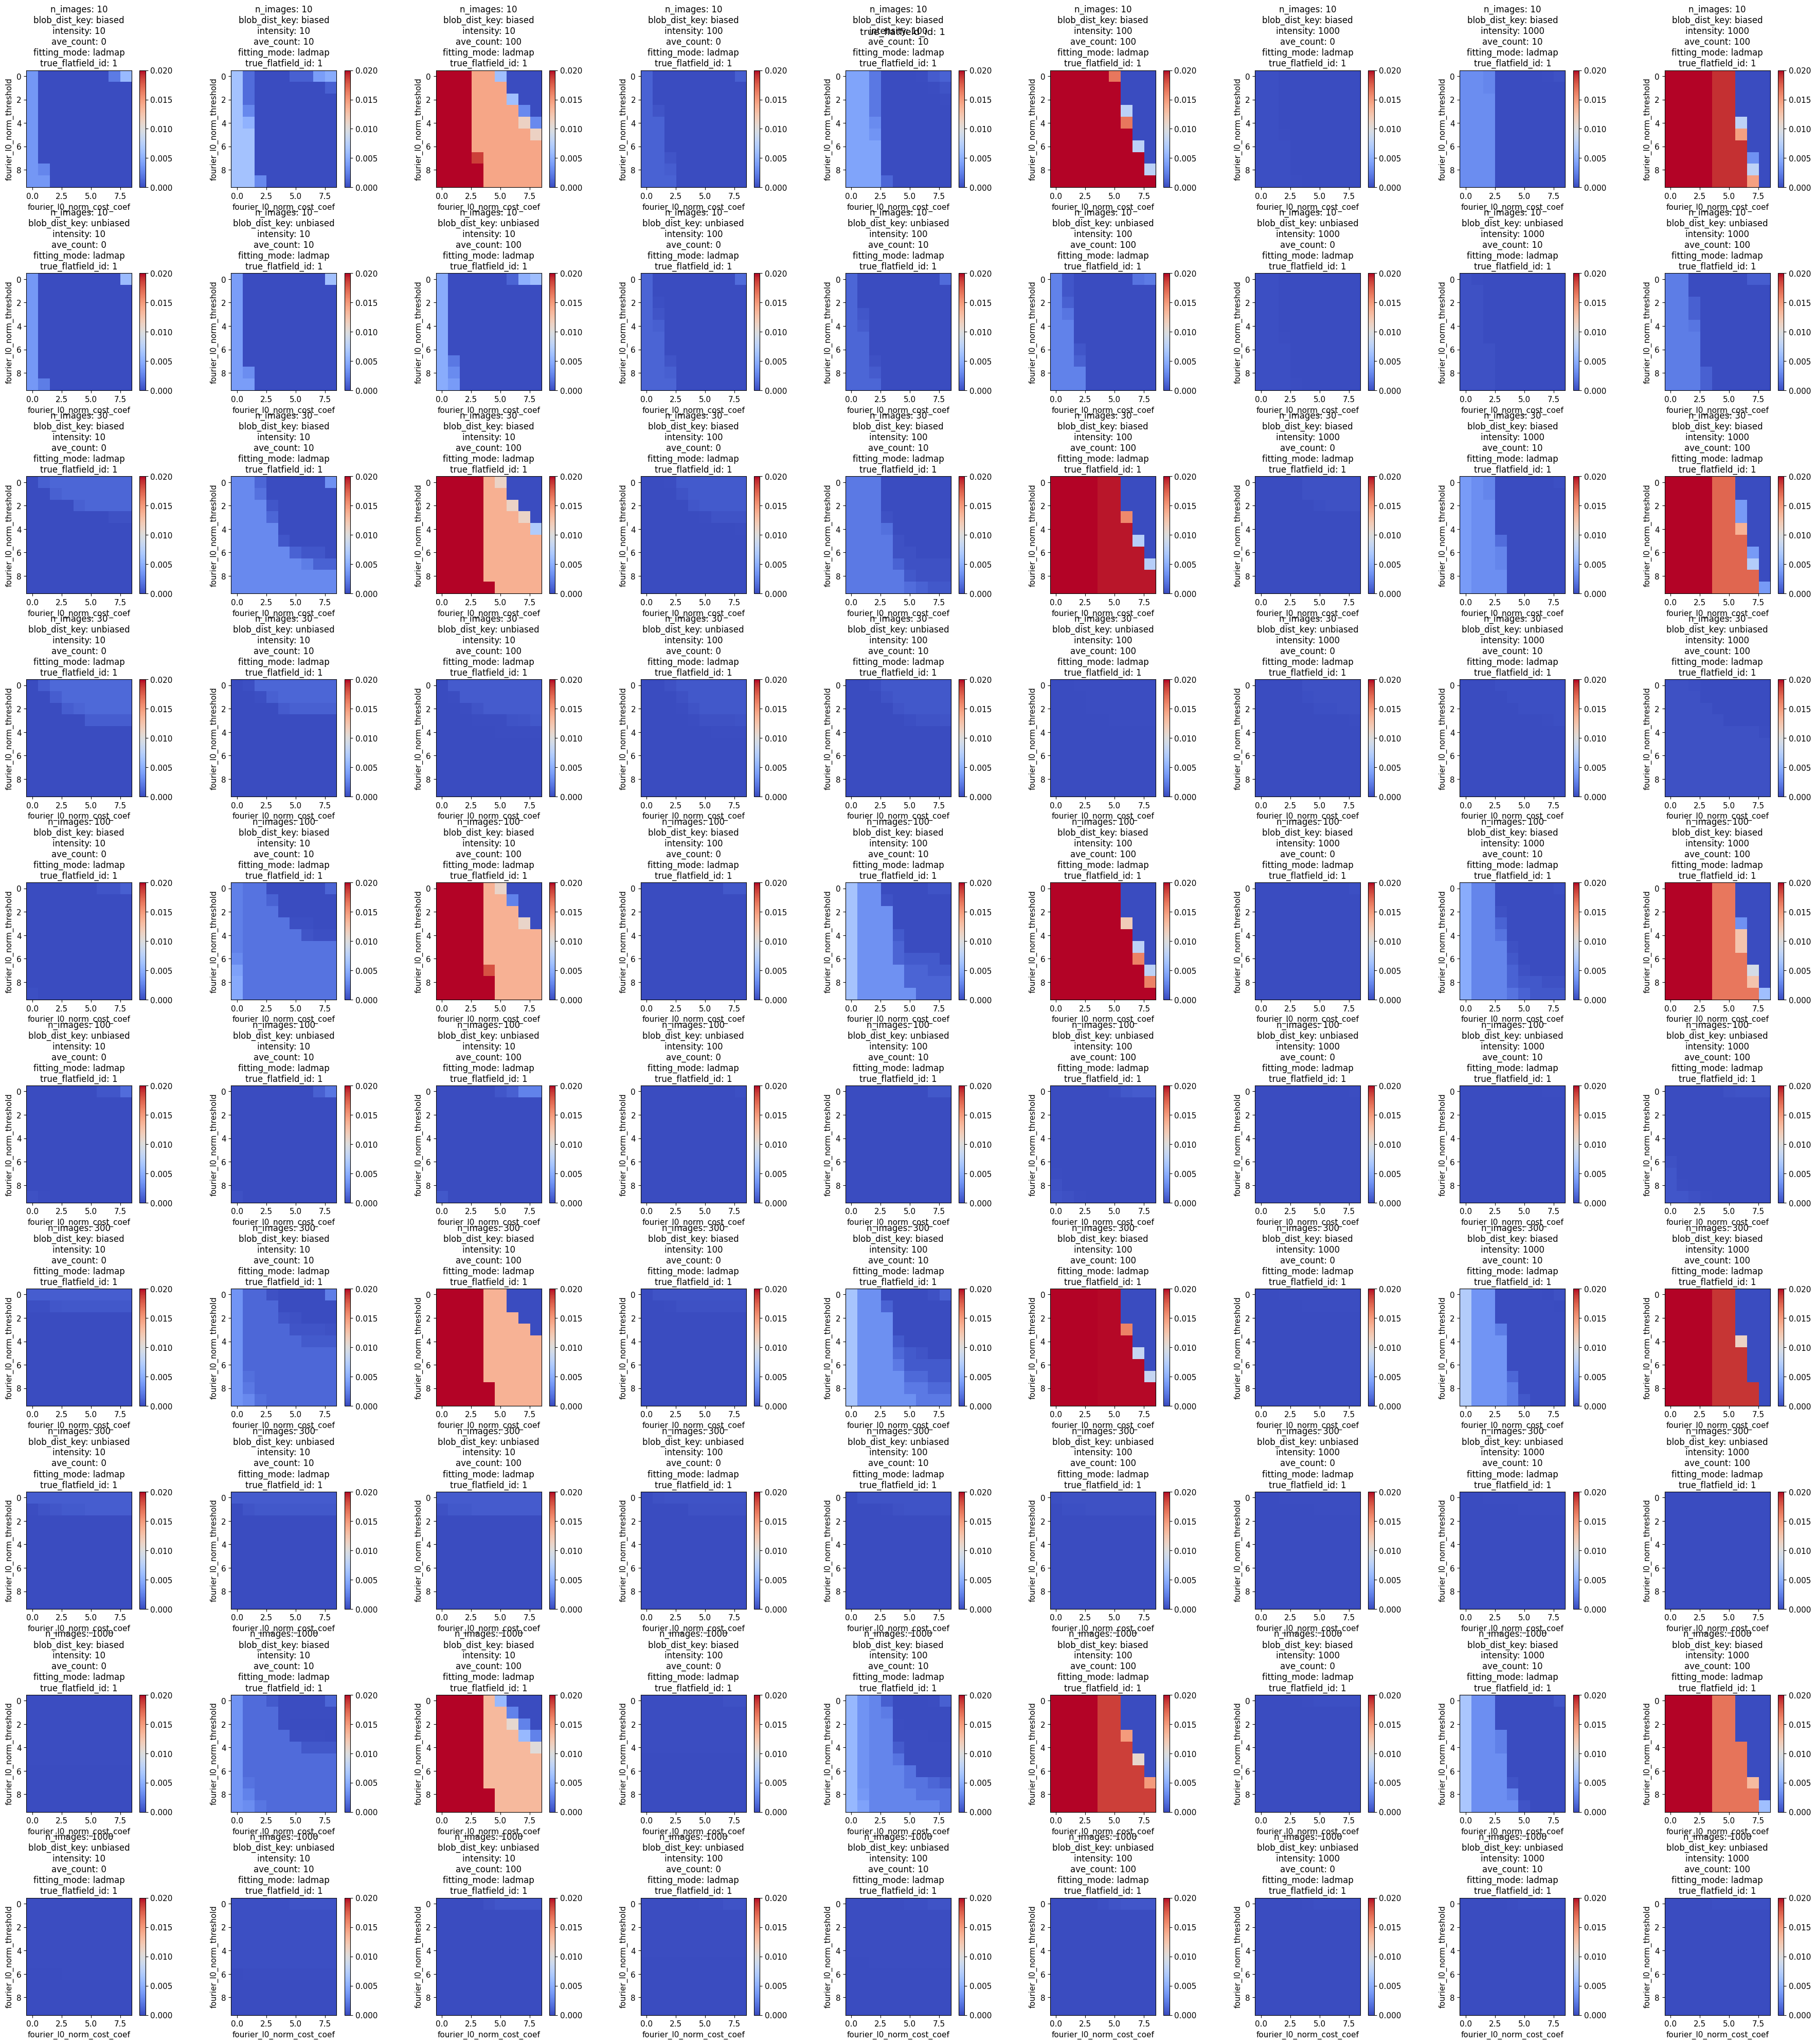

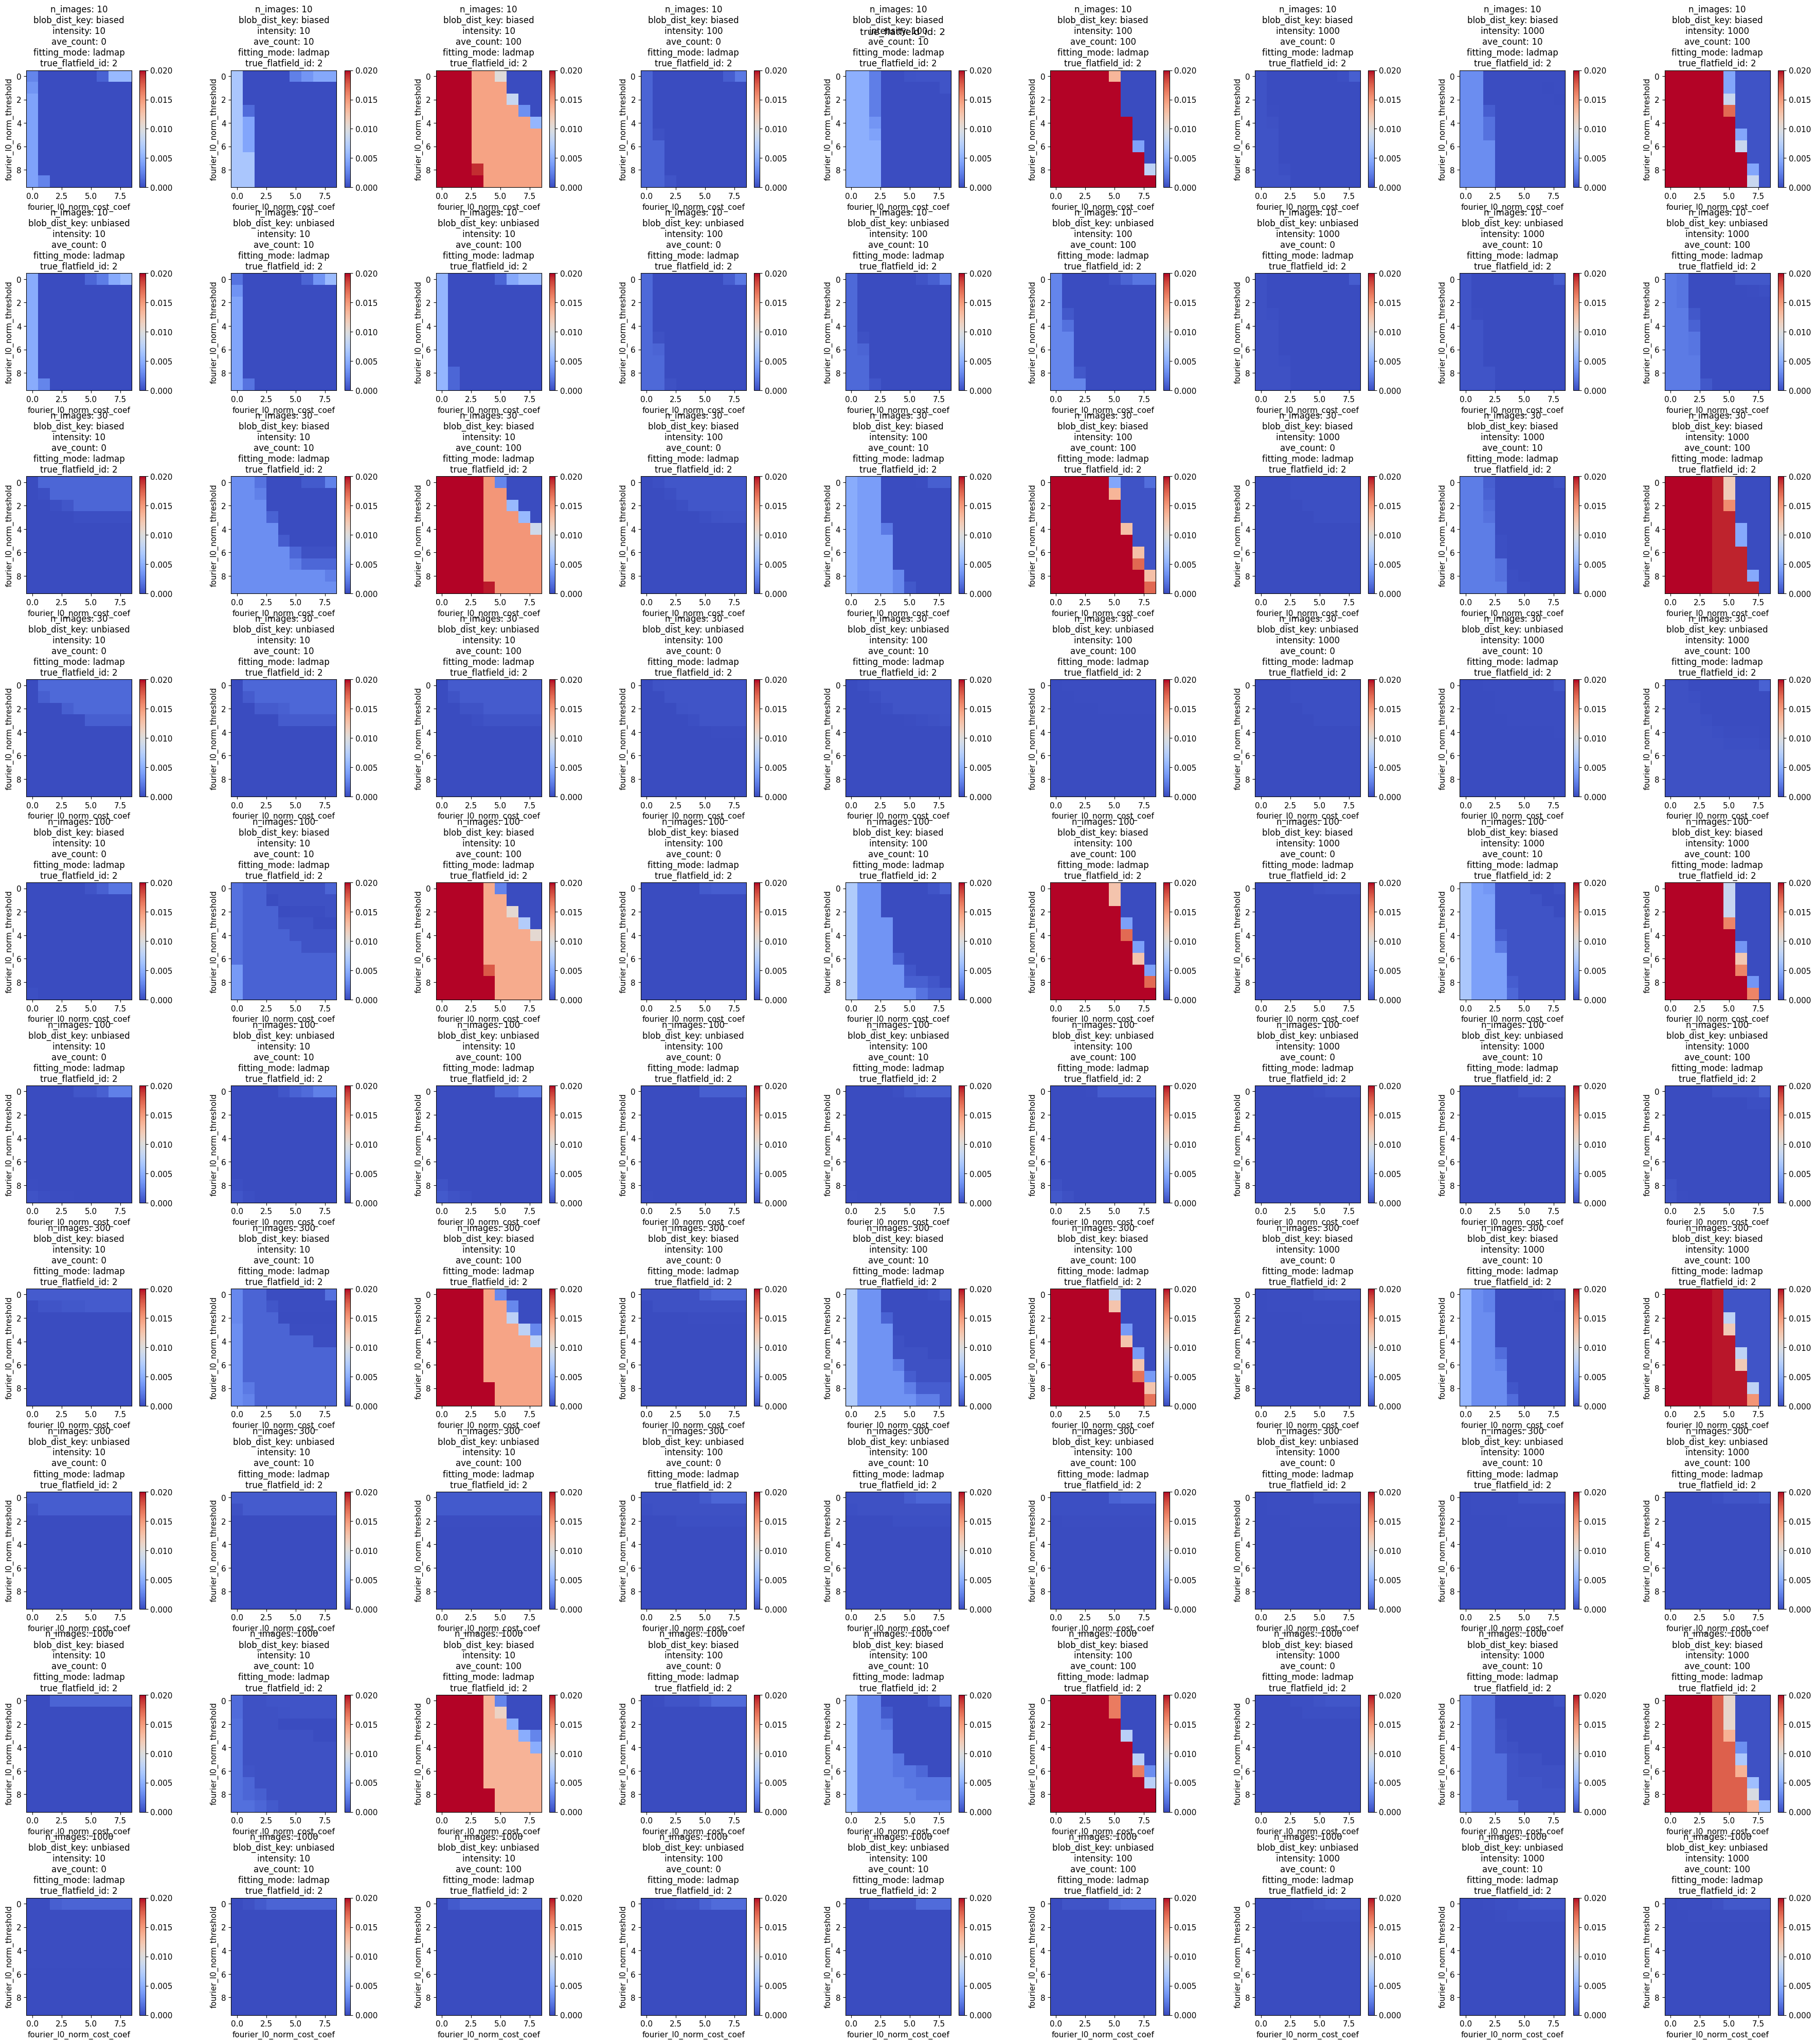

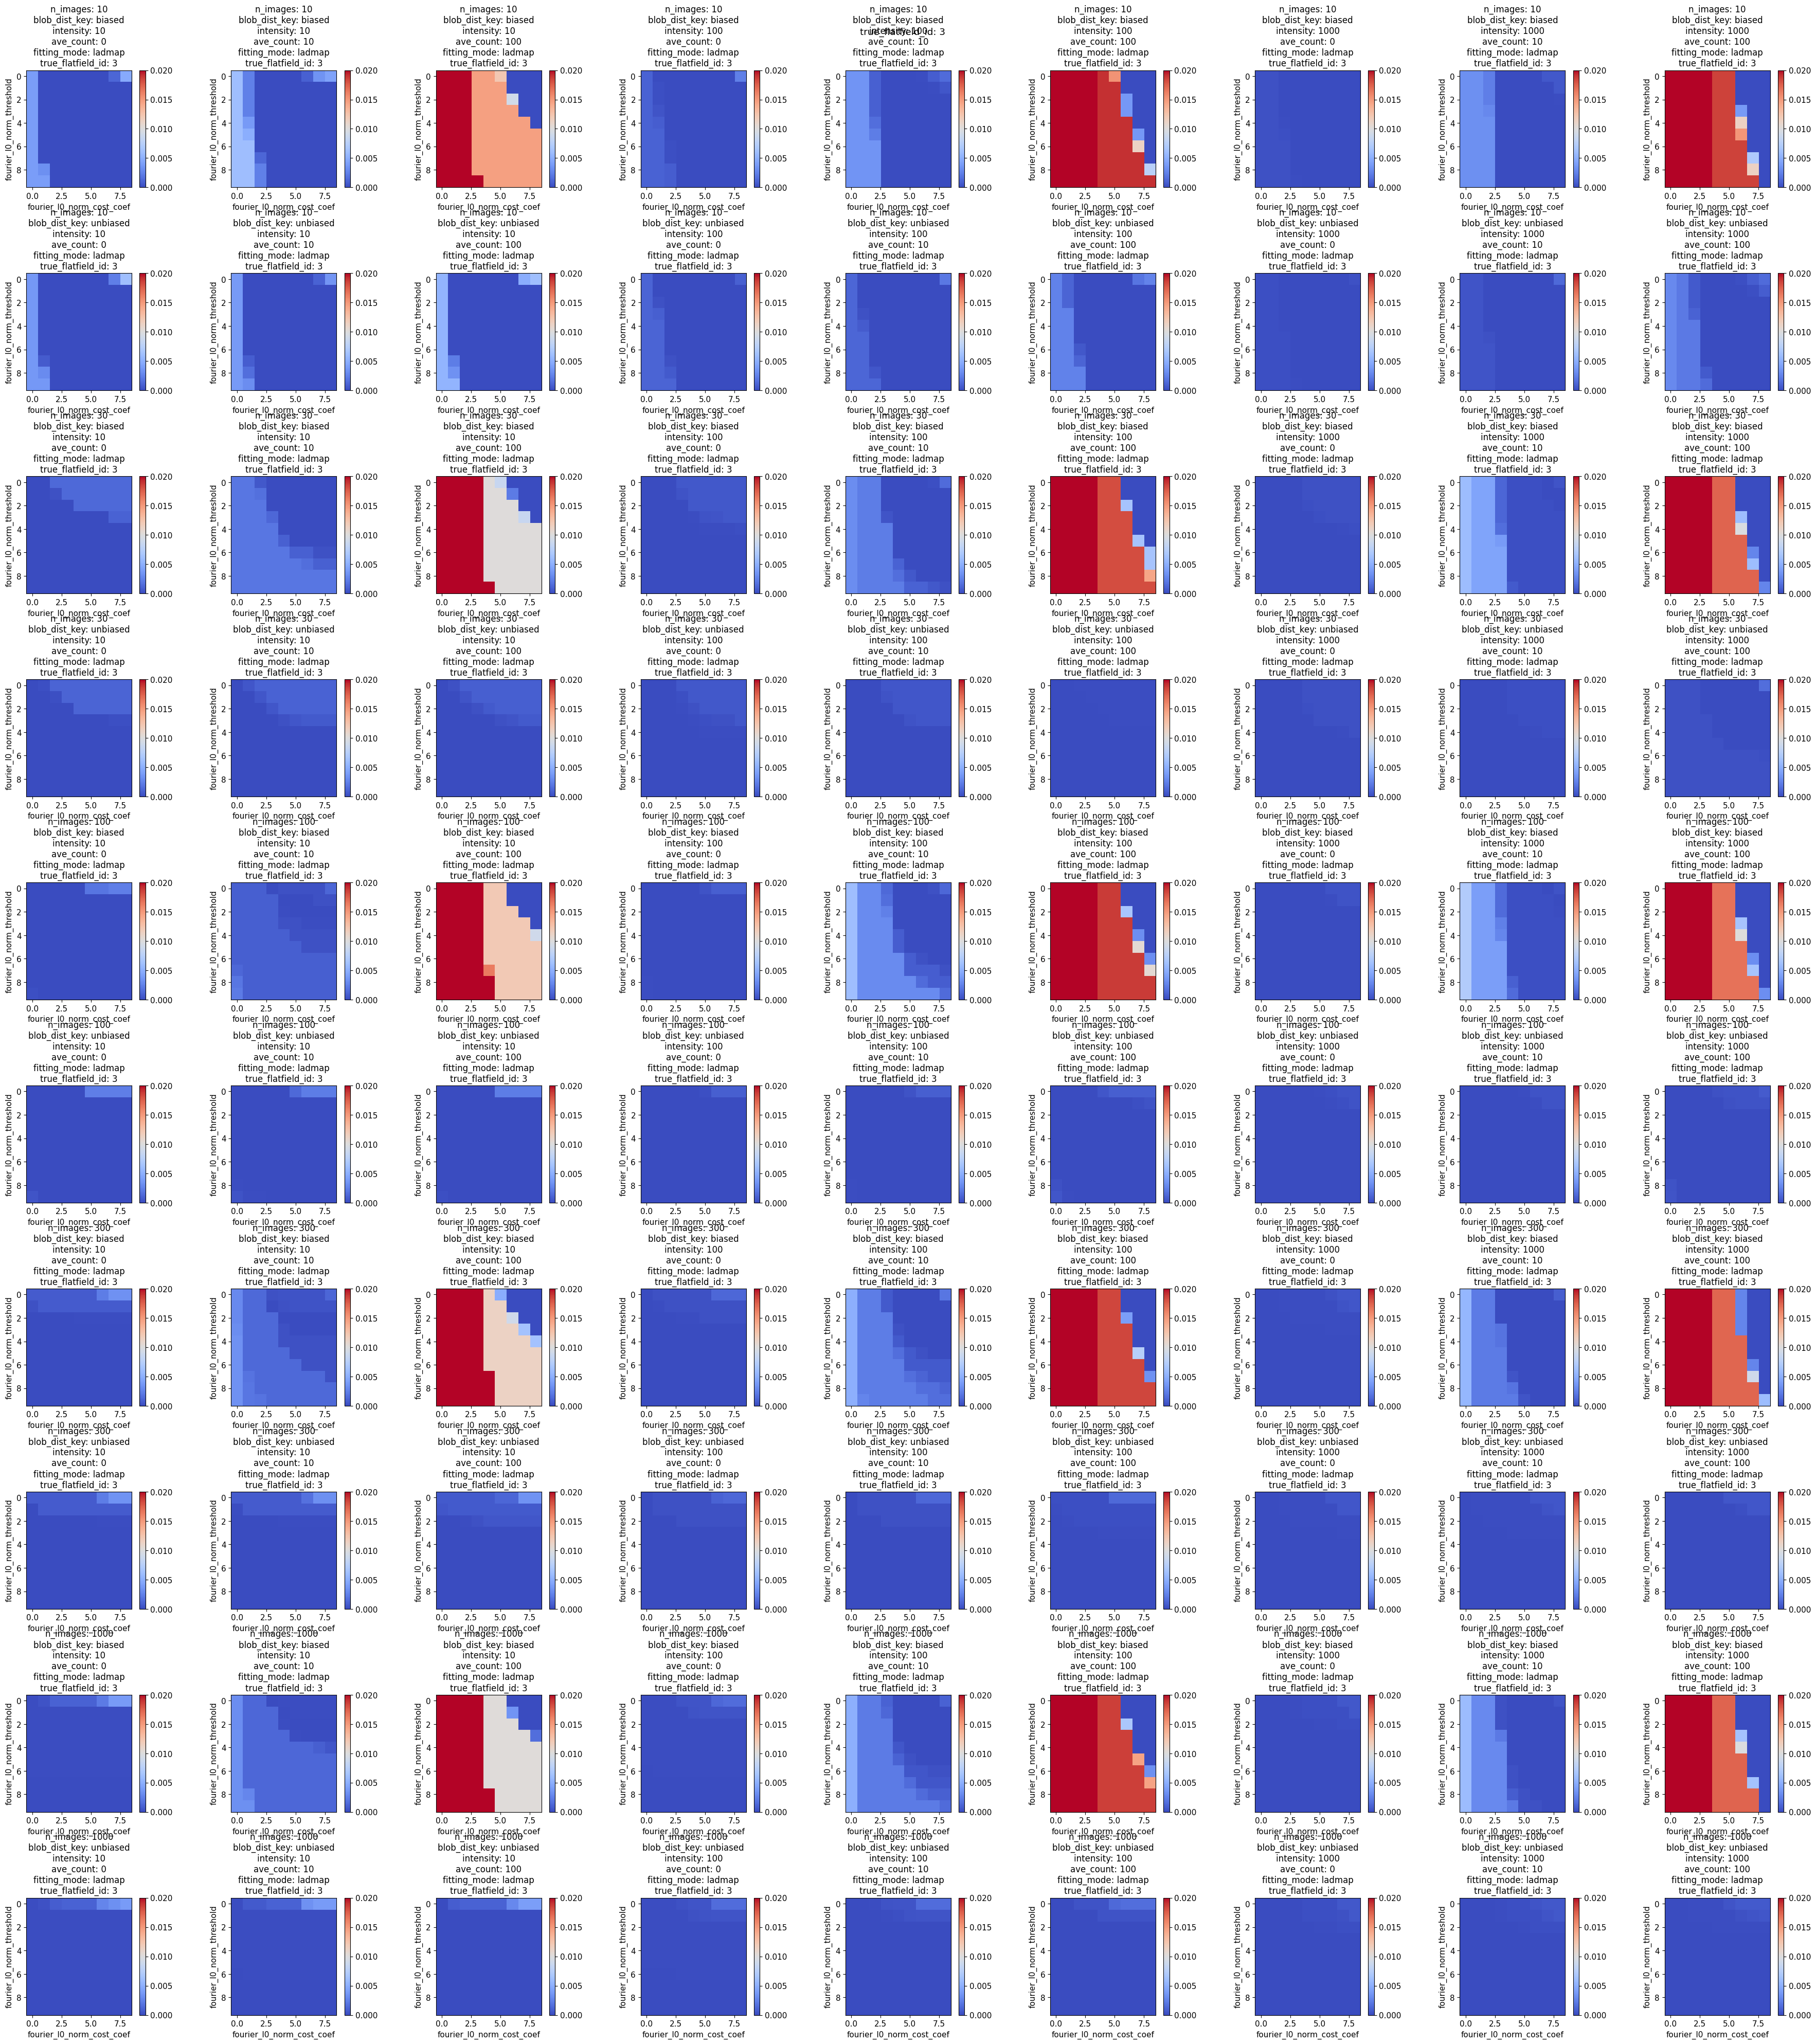

In [148]:
_df = deviation_df2[(deviation_df2["fitting_mode"] == "ladmap")]
for true_flatfield_id, grp0 in _df.groupby("true_flatfield_id"):
    ncols = 9
    nrows = (len(grp0.groupby(keys)) - 1) // ncols + 1
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4 * ncols, 4 * nrows),
        # gridspec_kw={"hspace": 1.5, "wspace": 1.0},
        dpi=50,
    )
    for ax, (vals, grp) in zip(axes.ravel(), grp0.groupby(keys)):
        # Reshape the data
        pivot_df = grp.pivot_table(
            values="deviation_diff",
            index="fourier_l0_norm_threshold",
            columns="fourier_l0_norm_cost_coef",
            fill_value=0,
        )["mean"]

        # Plot the heatmap
        im = ax.imshow(pivot_df, cmap="coolwarm", vmin=0, vmax=0.02)

        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax)

        # Set axis labels and title
        ax.set_xlabel("fourier_l0_norm_cost_coef")
        ax.set_ylabel("fourier_l0_norm_threshold")
        ax.set_title("Heatmap of deviation_diff mean values")

        ax.set_title(
            "\n".join([f"{k}: {v}" for k, v in zip(keys, vals)]),
        )
    fig.suptitle(f"true_flatfield_id: {true_flatfield_id}")
    fig.tight_layout()
    fig.show()

In [161]:
fourier_l0_norm_thresholds

array([0.        , 0.00111111, 0.00222222, 0.00333333, 0.00444444,
       0.00555556, 0.00666667, 0.00777778, 0.00888889, 0.01      ])

In [163]:
fourier_l0_norm_threshold = fourier_l0_norm_thresholds[-1]
fourier_l0_norm_cost_coef = sorted(deviation_df2["fourier_l0_norm_cost_coef"].unique())[
    6
]
print(fourier_l0_norm_cost_coef)

30


In [164]:
_df_selected = _df[
    (_df["fourier_l0_norm_threshold"] == fourier_l0_norm_threshold)
    & (_df["fourier_l0_norm_cost_coef"] == fourier_l0_norm_cost_coef)
]
_df_selected

n_images blob_dist_key intensity ave_count fitting_mode  \
                                                                
447         10        biased        10         0       ladmap   
537         10        biased        10         0       ladmap   
627         10        biased        10         0       ladmap   
717         10        biased        10         0       ladmap   
1167        10        biased        10        10       ladmap   
...        ...           ...       ...       ...          ...   
64077     1000      unbiased      1000        10       ladmap   
64527     1000      unbiased      1000       100       ladmap   
64617     1000      unbiased      1000       100       ladmap   
64707     1000      unbiased      1000       100       ladmap   
64797     1000      unbiased      1000       100       ladmap   

      true_flatfield_id fourier_l0_norm_threshold fourier_l0_norm_cost_coef  \
                                                                              
447                   0                      0.01                        30   
537                   1                      0.01                        30   
627                   2                      0.01                        30   
717                   3                      0.01                        30   
1167                  0                      0.01                        30   
...                 ...                       ...                       ...   
64077                 3                      0.01                        30   
64527                 0                      0.01                        30   
64617                 1                      0.01                        30   
64707                 2                      0.01                        30   
64797                 3                      0.01                        30   

      optimal_deviation estimated_deviation  rep deviation_diff  
                   mean                mean mean           mean  
447            0.005130            0.005130  2.0       0.000000  
537            0.006408            0.006408  2.0       0.000000  
627            0.005337            0.005337  2.0       0.000000  
717            0.005792            0.005792  2.0       0.000000  
1167           0.006252            0.006252  2.0       0.000000  
...                 ...                 ...  ...            ...  
64077          0.000290            0.000290  2.0       0.000000  
64527          0.000273            0.000373  2.0       0.000101  
64617          0.000528            0.000582  2.0       0.000054  
64707          0.000268            0.000342  2.0       0.000074  
64797          0.000362            0.000413  2.0       0.000051  

[360 rows x 12 columns]

array([[<Axes: title={'center': 'mean'}>]], dtype=object)

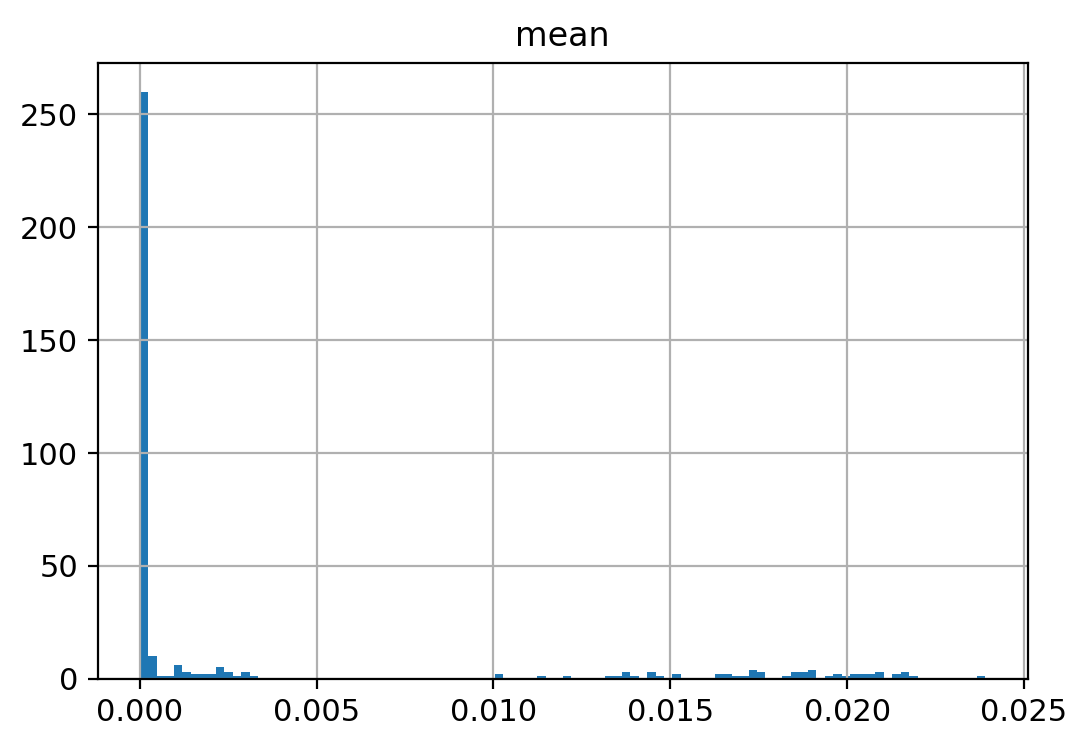

In [165]:
_df_selected["deviation_diff"].hist(bins=100)